<a href="https://colab.research.google.com/github/darja/NeuralUni/blob/master/gan_colored.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment

In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, MaxPool2D, Conv2DTranspose, ZeroPadding2D
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.merge import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from IPython.display import Image

from keras import backend as K


import os
import random
import sys
import datetime
import imageio

import numpy as np

Using TensorFlow backend.


## Input Files and Reading Operations

In [0]:
K.clear_session()

input_folder = "cargo_256"

In [4]:
!rm -rf {input_folder}
!unzip {input_folder}.zip

!rm -rf __MACOSX
!rm -rf {input_folder}/.ipynb_checkpoints
!rm -rf {input_folder}/.DS_Store

Archive:  cargo_256.zip
   creating: cargo_256/
  inflating: cargo_256/cargo_102.jpg  
  inflating: cargo_256/cargo_116.jpg  
  inflating: cargo_256/cargo_12.jpg  
  inflating: cargo_256/cargo_13.jpg  
  inflating: cargo_256/cargo_117.jpg  
  inflating: cargo_256/cargo_103.jpg  
  inflating: cargo_256/cargo_129.jpg  
  inflating: cargo_256/cargo_115.jpg  
  inflating: cargo_256/cargo_101.jpg  
  inflating: cargo_256/cargo_11.jpg  
  inflating: cargo_256/cargo_39.jpg  
  inflating: cargo_256/cargo_38.jpg  
  inflating: cargo_256/cargo_10.jpg  
  inflating: cargo_256/cargo_100.jpg  
  inflating: cargo_256/cargo_114.jpg  
  inflating: cargo_256/cargo_128.jpg  
  inflating: cargo_256/cargo_110.jpg  
  inflating: cargo_256/cargo_104.jpg  
  inflating: cargo_256/cargo_138.jpg  
  inflating: cargo_256/cargo_28.jpg  
  inflating: cargo_256/cargo_14.jpg  
  inflating: cargo_256/cargo_9.jpg   
  inflating: cargo_256/cargo_8.jpg   
  inflating: cargo_256/cargo_15.jpg  
  inflating: cargo_256/carg

In [0]:
def inputFiles():
    return os.listdir(input_folder)

def read_image(filename):
#     print(filename)
    path = "%s/%s" % (input_folder, filename)
    return imageio.imread(path)

def read_images(files):
#     read_func = np.vectorize(lambda x: read_image(x))
#     images = read_func(array(files))

    imgs = []
    for f in files:
        im = read_image(f)
#         print(im.shape)
        imgs.append(im)
    return np.array(imgs)


files = inputFiles()

### Sample image

cargo_9.jpg


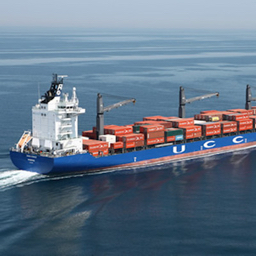

(256, 256, 3)


In [5]:
filename = files[5]
print(filename)
with open("%s/%s" % (input_folder, filename),'rb') as f:
    display(Image(data=f.read(), format='jpg'))
    
content = read_image(filename)
print(content.shape)

## Input Parameters

In [6]:
epochs = 30000
sample_interval = 100
log_interval = 20
latent_dim = 100
batch_size = 6

img_rows = 256
img_cols = 256
channels = 3

lr = 1e-4
# optimizer = Adam(lr)
optimizer = RMSprop(lr)


Instructions for updating:
Colocations handled automatically by placer.


## Output Folder

In [11]:
output_folder = "gen"
print(output_folder)
!rm -fr {output_folder}
!mkdir {output_folder}

gen


# GAN

In [8]:
# del gan
class GAN():
    def __init__(self):
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = latent_dim

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()       
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        self.combined.summary()


    def build_generator(self):
        print("Creating generator")
        
        model = Sequential(name="generator")

        model.add(Dense(self.img_rows * self.img_cols * self.channels, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((self.img_rows // 4, self.img_cols // 4, 16 * self.channels)))
        model.add(UpSampling2D())
        model.add(Conv2D(48, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(UpSampling2D())
        model.add(Conv2D(96, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        return model
#         noise = Input(shape=(self.latent_dim,))
#         img = model(noise)

#         return Model(noise, img)
    
    def build_discriminator(self):
        print("Creating discriminator")
        
        model = Sequential(name="discriminator")

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
#         model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
#         model.add(ZeroPadding2D(padding=((0,1),(0,1))))
#         model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
#         model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(Dropout(0.25))
#         model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
#         model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
#         model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        return model
        
#         img = Input(shape=self.img_shape)
#         validity = model(img)

#         return Model(img, validity)

    def train(self, epochs, batch_size=16, sample_interval=50):
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            random_files = random.sample(files, batch_size)
            imgs = read_images(random_files)
            imgs = imgs / 127.5 - 1

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Log progress
            if epoch % log_interval == 0:
                print ("%d [D loss: %f] [D acc.: %.2f%%, fake %.2f%%, real %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], 100*d_loss_fake[1], 100*d_loss_real[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 1, 1
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        gen_imgs = 0.5 * gen_imgs + 0.5
    
        imageio.imwrite("%s/%d.jpg" % (output_folder, epoch), gen_imgs[0])

gan = GAN()
gan.train(epochs=epochs + 1, batch_size=batch_size, sample_interval=sample_interval)



Creating discriminator
Creating generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
generator (Sequential)       (None, 256, 256, 3)       19922931  
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 70625     
Total params: 19,993,556
Trainable params: 19,922,643
Non-trainable params: 70,913
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.713497] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.510980]


20 [D loss: 0.771889] [D acc.: 50.00%, fake 0.00%, real 100.00%] [G loss: 0.633532]
40 [D loss: 0.617295] [D acc.: 50.00%, fake 16.67%, real 83.33%] [G loss: 1.222746]
60 [D loss: 0.784870] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.453819]
80 [D loss: 0.803306] [D acc.: 58.33%, fake 100.00%, real 16.67%] [G loss: 1.135108]


100 [D loss: 0.801410] [D acc.: 50.00%, fake 100.00%, real 0.00%] [G loss: 1.063514]
120 [D loss: 0.712276] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 1.208431]
140 [D loss: 0.741940] [D acc.: 41.67%, fake 83.33%, real 0.00%] [G loss: 1.202040]
160 [D loss: 0.595446] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 1.262181]
180 [D loss: 0.793794] [D acc.: 58.33%, fake 100.00%, real 16.67%] [G loss: 1.013362]


200 [D loss: 0.565155] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.336705]
220 [D loss: 0.771826] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.929903]
240 [D loss: 0.847373] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.844758]
260 [D loss: 0.675832] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 0.892991]
280 [D loss: 0.746587] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.543429]


300 [D loss: 0.844254] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.652372]
320 [D loss: 0.862623] [D acc.: 41.67%, fake 0.00%, real 83.33%] [G loss: 0.553598]
340 [D loss: 0.818731] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.451329]
360 [D loss: 0.732965] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.566630]
380 [D loss: 0.717697] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.419564]


400 [D loss: 0.738207] [D acc.: 41.67%, fake 0.00%, real 83.33%] [G loss: 0.513453]
420 [D loss: 0.582373] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 0.796091]
440 [D loss: 0.861277] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.573022]
460 [D loss: 0.880124] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.717722]
480 [D loss: 0.784793] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 0.738048]


500 [D loss: 0.675325] [D acc.: 58.33%, fake 33.33%, real 83.33%] [G loss: 0.626467]
520 [D loss: 0.771695] [D acc.: 58.33%, fake 100.00%, real 16.67%] [G loss: 0.916839]
540 [D loss: 0.719487] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 0.816058]
560 [D loss: 0.705765] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 0.924757]
580 [D loss: 0.653550] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.065566]


600 [D loss: 0.635852] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.609825]
620 [D loss: 0.742481] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.909107]
640 [D loss: 0.765065] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.698442]
660 [D loss: 0.560446] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 0.345928]
680 [D loss: 0.843225] [D acc.: 25.00%, fake 50.00%, real 0.00%] [G loss: 0.796499]


700 [D loss: 0.712666] [D acc.: 41.67%, fake 83.33%, real 0.00%] [G loss: 0.963814]
720 [D loss: 0.718366] [D acc.: 41.67%, fake 0.00%, real 83.33%] [G loss: 0.591517]
740 [D loss: 0.802156] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.850014]
760 [D loss: 0.830078] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.653097]
780 [D loss: 0.883658] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.805832]


800 [D loss: 0.746602] [D acc.: 50.00%, fake 100.00%, real 0.00%] [G loss: 0.981522]
820 [D loss: 0.395327] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 1.259218]
840 [D loss: 0.847783] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.459761]
860 [D loss: 0.712455] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 0.694005]
880 [D loss: 0.849496] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.912047]


900 [D loss: 0.778503] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 1.045042]
920 [D loss: 0.741956] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.592071]
940 [D loss: 0.733576] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.748226]
960 [D loss: 0.557720] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.945880]
980 [D loss: 0.522689] [D acc.: 83.33%, fake 66.67%, real 100.00%] [G loss: 0.748246]


1000 [D loss: 0.818019] [D acc.: 41.67%, fake 83.33%, real 0.00%] [G loss: 0.831615]
1020 [D loss: 0.916753] [D acc.: 33.33%, fake 66.67%, real 0.00%] [G loss: 0.890762]
1040 [D loss: 0.743784] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.899357]
1060 [D loss: 0.845248] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.662879]
1080 [D loss: 0.753839] [D acc.: 41.67%, fake 0.00%, real 83.33%] [G loss: 0.610534]


1100 [D loss: 0.807672] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.558707]
1120 [D loss: 0.728630] [D acc.: 33.33%, fake 66.67%, real 0.00%] [G loss: 0.885501]
1140 [D loss: 0.708628] [D acc.: 66.67%, fake 50.00%, real 83.33%] [G loss: 0.652046]
1160 [D loss: 0.631587] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 0.582310]
1180 [D loss: 0.732275] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.858986]


1200 [D loss: 0.691019] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 1.102848]
1220 [D loss: 0.588614] [D acc.: 75.00%, fake 66.67%, real 83.33%] [G loss: 0.680178]
1240 [D loss: 0.323993] [D acc.: 91.67%, fake 83.33%, real 100.00%] [G loss: 0.935507]
1260 [D loss: 0.612945] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 1.058911]
1280 [D loss: 0.772341] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.786384]


1300 [D loss: 0.648514] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 1.032309]
1320 [D loss: 0.828523] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 0.939181]
1340 [D loss: 0.830430] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.010102]
1360 [D loss: 0.630767] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 0.631771]
1380 [D loss: 0.503650] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 1.034600]


1400 [D loss: 0.671703] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.483863]
1420 [D loss: 0.637589] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.004216]
1440 [D loss: 0.716596] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 0.996934]
1460 [D loss: 0.773670] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.750008]
1480 [D loss: 0.880174] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.679626]


1500 [D loss: 0.886922] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.950956]
1520 [D loss: 0.532124] [D acc.: 66.67%, fake 33.33%, real 100.00%] [G loss: 1.277145]
1540 [D loss: 0.720575] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.654591]
1560 [D loss: 0.768034] [D acc.: 66.67%, fake 33.33%, real 100.00%] [G loss: 0.562969]
1580 [D loss: 0.911655] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.939435]


1600 [D loss: 1.024017] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.683206]
1620 [D loss: 0.604381] [D acc.: 58.33%, fake 16.67%, real 100.00%] [G loss: 0.676249]
1640 [D loss: 0.746345] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 1.024780]
1660 [D loss: 0.850883] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.784688]
1680 [D loss: 0.766343] [D acc.: 50.00%, fake 16.67%, real 83.33%] [G loss: 0.780363]


1700 [D loss: 0.604099] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 0.525182]
1720 [D loss: 0.933299] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.155147]
1740 [D loss: 0.658733] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 1.082713]
1760 [D loss: 0.856698] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 0.834693]
1780 [D loss: 0.773215] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.734075]


1800 [D loss: 0.943391] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.912073]
1820 [D loss: 0.813593] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.783017]
1840 [D loss: 0.652093] [D acc.: 50.00%, fake 0.00%, real 100.00%] [G loss: 0.670438]
1860 [D loss: 0.728201] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.691781]
1880 [D loss: 0.865227] [D acc.: 41.67%, fake 66.67%, real 16.67%] [G loss: 0.847494]


1900 [D loss: 0.933377] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.962799]
1920 [D loss: 0.818564] [D acc.: 33.33%, fake 66.67%, real 0.00%] [G loss: 1.039438]
1940 [D loss: 0.590943] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 1.038868]
1960 [D loss: 0.841194] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.475402]
1980 [D loss: 0.669027] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.619638]


2000 [D loss: 0.887478] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 0.854829]
2020 [D loss: 0.652529] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 0.889776]
2040 [D loss: 0.630893] [D acc.: 66.67%, fake 50.00%, real 83.33%] [G loss: 0.769114]
2060 [D loss: 0.885490] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.654056]
2080 [D loss: 0.881008] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.758444]


2100 [D loss: 0.794609] [D acc.: 25.00%, fake 50.00%, real 0.00%] [G loss: 0.754181]
2120 [D loss: 0.810611] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 1.051315]
2140 [D loss: 0.688074] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 1.269806]
2160 [D loss: 0.824728] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.417183]
2180 [D loss: 0.763572] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.765985]


2200 [D loss: 0.455946] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 1.080325]
2220 [D loss: 1.283361] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.482863]
2240 [D loss: 0.786178] [D acc.: 41.67%, fake 66.67%, real 16.67%] [G loss: 0.796055]
2260 [D loss: 0.856261] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.810057]
2280 [D loss: 0.703074] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.557201]


2300 [D loss: 0.768502] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 0.923844]
2320 [D loss: 0.707437] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.768715]
2340 [D loss: 0.684835] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 0.982162]
2360 [D loss: 0.706263] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.745504]
2380 [D loss: 0.948907] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.501378]


2400 [D loss: 0.829196] [D acc.: 41.67%, fake 83.33%, real 0.00%] [G loss: 0.676628]
2420 [D loss: 0.703000] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.911528]
2440 [D loss: 1.013708] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.575753]
2460 [D loss: 0.888696] [D acc.: 41.67%, fake 66.67%, real 16.67%] [G loss: 0.691649]
2480 [D loss: 0.728932] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 0.881275]


2500 [D loss: 0.873400] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.660497]
2520 [D loss: 0.579771] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.455933]
2540 [D loss: 0.700792] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.746899]
2560 [D loss: 0.719758] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 1.133096]
2580 [D loss: 0.789019] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.320873]


2600 [D loss: 0.937416] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.821500]
2620 [D loss: 0.710364] [D acc.: 41.67%, fake 0.00%, real 83.33%] [G loss: 0.713586]
2640 [D loss: 0.735439] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.824745]
2660 [D loss: 0.904028] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.808432]
2680 [D loss: 0.733758] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.780271]


2700 [D loss: 0.756027] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.826594]
2720 [D loss: 0.895009] [D acc.: 16.67%, fake 33.33%, real 0.00%] [G loss: 0.750733]
2740 [D loss: 0.606951] [D acc.: 75.00%, fake 66.67%, real 83.33%] [G loss: 0.371763]
2760 [D loss: 0.478429] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 1.302308]
2780 [D loss: 1.002021] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.440437]


2800 [D loss: 0.586862] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.383869]
2820 [D loss: 0.498527] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 0.376767]
2840 [D loss: 0.714159] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.699557]
2860 [D loss: 0.791382] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.569859]
2880 [D loss: 0.759266] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 0.834299]


2900 [D loss: 0.613736] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.748960]
2920 [D loss: 0.599827] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 0.925736]
2940 [D loss: 0.512700] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.827886]
2960 [D loss: 0.903130] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 0.660483]
2980 [D loss: 0.716176] [D acc.: 41.67%, fake 66.67%, real 16.67%] [G loss: 1.301874]


3000 [D loss: 0.898387] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.483517]
3020 [D loss: 0.726773] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 0.335081]
3040 [D loss: 0.519386] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 0.392983]
3060 [D loss: 0.835599] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 0.968447]
3080 [D loss: 0.789026] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.138407]


3100 [D loss: 0.956742] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.556415]
3120 [D loss: 0.641394] [D acc.: 50.00%, fake 16.67%, real 83.33%] [G loss: 0.589129]
3140 [D loss: 0.273279] [D acc.: 100.00%, fake 100.00%, real 100.00%] [G loss: 0.695894]
3160 [D loss: 0.828580] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.810086]
3180 [D loss: 0.894878] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.278011]


3200 [D loss: 0.590144] [D acc.: 58.33%, fake 16.67%, real 100.00%] [G loss: 0.246297]
3220 [D loss: 0.723999] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.673393]
3240 [D loss: 0.454007] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.713898]
3260 [D loss: 0.738999] [D acc.: 50.00%, fake 100.00%, real 0.00%] [G loss: 0.845468]
3280 [D loss: 0.477496] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.058031]


3300 [D loss: 0.658377] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 0.887519]
3320 [D loss: 0.931682] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.431062]
3340 [D loss: 1.007274] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.389431]
3360 [D loss: 0.548379] [D acc.: 100.00%, fake 100.00%, real 100.00%] [G loss: 0.568018]
3380 [D loss: 0.761429] [D acc.: 50.00%, fake 100.00%, real 0.00%] [G loss: 0.536715]


3400 [D loss: 0.675118] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 0.788084]
3420 [D loss: 0.560982] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 0.666330]
3440 [D loss: 0.783077] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.694247]
3460 [D loss: 0.826384] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.745192]
3480 [D loss: 0.930265] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.503992]


3500 [D loss: 0.812108] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.660004]
3520 [D loss: 0.692744] [D acc.: 50.00%, fake 0.00%, real 100.00%] [G loss: 0.707295]
3540 [D loss: 0.901870] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 0.710251]
3560 [D loss: 0.872806] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.538754]
3580 [D loss: 0.738835] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 0.568011]


3600 [D loss: 0.540024] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 1.157647]
3620 [D loss: 0.769545] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 0.847650]
3640 [D loss: 0.838519] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.778507]
3660 [D loss: 0.775869] [D acc.: 58.33%, fake 100.00%, real 16.67%] [G loss: 0.896812]
3680 [D loss: 0.752399] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 0.668195]


3700 [D loss: 1.230966] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.532461]
3720 [D loss: 0.719078] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.501357]
3740 [D loss: 0.656090] [D acc.: 50.00%, fake 16.67%, real 83.33%] [G loss: 0.269305]
3760 [D loss: 0.903762] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.572573]
3780 [D loss: 0.928544] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.586311]


3800 [D loss: 0.921719] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.361047]
3820 [D loss: 0.981292] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.220964]
3840 [D loss: 0.750430] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.451578]
3860 [D loss: 0.404566] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.549922]
3880 [D loss: 0.632479] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.870286]


3900 [D loss: 0.512001] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.286029]
3920 [D loss: 0.859517] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.799762]
3940 [D loss: 0.595225] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.166373]
3960 [D loss: 0.806989] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.762267]
3980 [D loss: 0.771422] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.272048]


4000 [D loss: 1.010708] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.432737]
4020 [D loss: 0.600007] [D acc.: 58.33%, fake 33.33%, real 83.33%] [G loss: 0.469265]
4040 [D loss: 0.524551] [D acc.: 75.00%, fake 66.67%, real 83.33%] [G loss: 0.317770]
4060 [D loss: 0.645659] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.529524]
4080 [D loss: 0.509800] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.858055]


4100 [D loss: 0.460304] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.483601]
4120 [D loss: 0.629620] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 0.894570]
4140 [D loss: 0.489895] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.365637]
4160 [D loss: 0.829700] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.821711]
4180 [D loss: 0.315303] [D acc.: 100.00%, fake 100.00%, real 100.00%] [G loss: 1.214185]


4200 [D loss: 0.700494] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.664897]
4220 [D loss: 0.538486] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.600540]
4240 [D loss: 0.736243] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.637653]
4260 [D loss: 0.796909] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.727558]
4280 [D loss: 0.631172] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.948227]


4300 [D loss: 0.818482] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.468001]
4320 [D loss: 0.689660] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.450390]
4340 [D loss: 0.297974] [D acc.: 100.00%, fake 100.00%, real 100.00%] [G loss: 0.305560]
4360 [D loss: 0.900413] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.746139]
4380 [D loss: 0.648279] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 1.175142]


4400 [D loss: 1.016269] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.323299]
4420 [D loss: 0.769531] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.362775]
4440 [D loss: 1.066527] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.274874]
4460 [D loss: 0.694957] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.151991]
4480 [D loss: 0.968396] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.507344]


4500 [D loss: 0.832667] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.579393]
4520 [D loss: 0.779947] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.505235]
4540 [D loss: 0.798526] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.036578]
4560 [D loss: 0.785828] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.192353]
4580 [D loss: 0.607359] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 0.476224]


4600 [D loss: 0.852511] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.285895]
4620 [D loss: 0.724960] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.259987]
4640 [D loss: 0.793917] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.350147]
4660 [D loss: 0.816826] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.219144]
4680 [D loss: 0.745337] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.245563]


4700 [D loss: 0.676169] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 0.403675]
4720 [D loss: 0.816830] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.193028]
4740 [D loss: 0.644532] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 0.238231]
4760 [D loss: 1.081425] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.373062]
4780 [D loss: 0.761797] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.434880]


4800 [D loss: 0.832745] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.829499]
4820 [D loss: 0.676937] [D acc.: 66.67%, fake 50.00%, real 83.33%] [G loss: 0.758504]
4840 [D loss: 1.114569] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.443127]
4860 [D loss: 0.788402] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.518628]
4880 [D loss: 0.863516] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.667756]


4900 [D loss: 0.751252] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.333240]
4920 [D loss: 1.044865] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.560602]
4940 [D loss: 0.739437] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.739565]
4960 [D loss: 0.836653] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.607480]
4980 [D loss: 0.355332] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.989326]


5000 [D loss: 0.886594] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 0.750500]
5020 [D loss: 0.879791] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.556833]
5040 [D loss: 0.869982] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.688554]
5060 [D loss: 0.772972] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.815790]
5080 [D loss: 0.749444] [D acc.: 50.00%, fake 16.67%, real 83.33%] [G loss: 0.655393]


5100 [D loss: 0.760915] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.278534]
5120 [D loss: 0.969199] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.681502]
5140 [D loss: 0.683167] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.445806]
5160 [D loss: 0.812398] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.550834]
5180 [D loss: 0.630978] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 0.567802]


5200 [D loss: 0.760634] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.308262]
5220 [D loss: 0.686222] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 1.036387]
5240 [D loss: 0.741013] [D acc.: 58.33%, fake 100.00%, real 16.67%] [G loss: 1.460999]
5260 [D loss: 0.757527] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.858053]
5280 [D loss: 0.738296] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.378840]


5300 [D loss: 0.567766] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 0.826422]
5320 [D loss: 0.727114] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 1.195848]
5340 [D loss: 0.734352] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.618523]
5360 [D loss: 0.819959] [D acc.: 50.00%, fake 16.67%, real 83.33%] [G loss: 0.373093]
5380 [D loss: 0.968365] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.664617]


5400 [D loss: 0.665197] [D acc.: 50.00%, fake 16.67%, real 83.33%] [G loss: 0.261130]
5420 [D loss: 0.887989] [D acc.: 41.67%, fake 0.00%, real 83.33%] [G loss: 0.522750]
5440 [D loss: 0.597784] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 0.416223]
5460 [D loss: 0.371070] [D acc.: 100.00%, fake 100.00%, real 100.00%] [G loss: 0.557007]
5480 [D loss: 0.754709] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.544395]


5500 [D loss: 0.572407] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 0.306078]
5520 [D loss: 0.595802] [D acc.: 66.67%, fake 50.00%, real 83.33%] [G loss: 0.743046]
5540 [D loss: 0.481961] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.682681]
5560 [D loss: 0.595831] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 0.607303]
5580 [D loss: 0.926691] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.602137]


5600 [D loss: 0.818272] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.850299]
5620 [D loss: 1.230973] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.650623]
5640 [D loss: 0.599011] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 0.444686]
5660 [D loss: 0.537353] [D acc.: 50.00%, fake 16.67%, real 83.33%] [G loss: 0.334448]
5680 [D loss: 0.769979] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.409653]


5700 [D loss: 0.499096] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.362532]
5720 [D loss: 0.704040] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.917759]
5740 [D loss: 0.886124] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 1.239209]
5760 [D loss: 0.822170] [D acc.: 41.67%, fake 0.00%, real 83.33%] [G loss: 0.259648]
5780 [D loss: 0.704276] [D acc.: 41.67%, fake 0.00%, real 83.33%] [G loss: 0.386332]


5800 [D loss: 0.452869] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.449618]
5820 [D loss: 0.737902] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 0.825034]
5840 [D loss: 0.929005] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.599247]
5860 [D loss: 0.836980] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.855265]
5880 [D loss: 0.378693] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.913570]


5900 [D loss: 0.856749] [D acc.: 58.33%, fake 100.00%, real 16.67%] [G loss: 0.992152]
5920 [D loss: 0.778879] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 0.600210]
5940 [D loss: 0.813901] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.361578]
5960 [D loss: 0.886631] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.192323]
5980 [D loss: 0.891905] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.303053]


6000 [D loss: 0.715150] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.302087]
6020 [D loss: 0.617858] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.101322]
6040 [D loss: 0.883839] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 0.820459]
6060 [D loss: 0.655273] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 1.027115]
6080 [D loss: 0.812394] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.917734]


6100 [D loss: 1.111606] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.480478]
6120 [D loss: 0.661646] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.394153]
6140 [D loss: 0.757969] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.540508]
6160 [D loss: 0.229101] [D acc.: 100.00%, fake 100.00%, real 100.00%] [G loss: 0.560189]
6180 [D loss: 0.649196] [D acc.: 66.67%, fake 50.00%, real 83.33%] [G loss: 0.641000]


6200 [D loss: 1.146803] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.479140]
6220 [D loss: 0.816375] [D acc.: 50.00%, fake 0.00%, real 100.00%] [G loss: 0.443939]
6240 [D loss: 0.664669] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.383250]
6260 [D loss: 0.757095] [D acc.: 41.67%, fake 0.00%, real 83.33%] [G loss: 0.273608]
6280 [D loss: 0.597731] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.477763]


6300 [D loss: 0.708978] [D acc.: 41.67%, fake 83.33%, real 0.00%] [G loss: 1.316910]
6320 [D loss: 0.638113] [D acc.: 58.33%, fake 100.00%, real 16.67%] [G loss: 2.087443]
6340 [D loss: 0.923832] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.616835]
6360 [D loss: 0.786155] [D acc.: 50.00%, fake 16.67%, real 83.33%] [G loss: 0.283781]
6380 [D loss: 0.840351] [D acc.: 41.67%, fake 0.00%, real 83.33%] [G loss: 0.155316]


6400 [D loss: 0.846373] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.357301]
6420 [D loss: 0.928495] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.350111]
6440 [D loss: 0.856197] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.747266]
6460 [D loss: 0.448820] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.943790]
6480 [D loss: 1.011050] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.451831]


6500 [D loss: 0.539215] [D acc.: 50.00%, fake 16.67%, real 83.33%] [G loss: 0.809727]
6520 [D loss: 0.476800] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 0.970585]
6540 [D loss: 1.232598] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.451524]
6560 [D loss: 0.742305] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.332266]
6580 [D loss: 1.148525] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.356623]


6600 [D loss: 1.020965] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.935769]
6620 [D loss: 0.620615] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 0.666041]
6640 [D loss: 0.697050] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 0.509172]
6660 [D loss: 0.612961] [D acc.: 58.33%, fake 33.33%, real 83.33%] [G loss: 0.705564]
6680 [D loss: 0.905545] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.692601]


6700 [D loss: 0.860665] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.501673]
6720 [D loss: 0.813785] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.490289]
6740 [D loss: 0.825285] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 0.604724]
6760 [D loss: 0.798494] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.673357]
6780 [D loss: 0.793246] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.308806]


6800 [D loss: 0.317991] [D acc.: 100.00%, fake 100.00%, real 100.00%] [G loss: 0.579194]
6820 [D loss: 0.565104] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.260119]
6840 [D loss: 0.675346] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 1.513520]
6860 [D loss: 0.853536] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.567280]
6880 [D loss: 1.081134] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.273681]


6900 [D loss: 0.614718] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.598240]
6920 [D loss: 0.471404] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.230454]
6940 [D loss: 1.226319] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.247840]
6960 [D loss: 0.818643] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.612168]
6980 [D loss: 0.600781] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 0.291255]


7000 [D loss: 0.483007] [D acc.: 83.33%, fake 66.67%, real 100.00%] [G loss: 1.318620]
7020 [D loss: 1.012960] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.511690]
7040 [D loss: 0.911767] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.099875]
7060 [D loss: 0.647334] [D acc.: 58.33%, fake 33.33%, real 83.33%] [G loss: 0.183673]
7080 [D loss: 0.385092] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.469181]


7100 [D loss: 0.985400] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.848052]
7120 [D loss: 0.968933] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.897242]
7140 [D loss: 0.868104] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.797996]
7160 [D loss: 0.746650] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.622206]
7180 [D loss: 0.286336] [D acc.: 100.00%, fake 100.00%, real 100.00%] [G loss: 1.892990]


7200 [D loss: 0.902602] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.814400]
7220 [D loss: 0.916030] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.482183]
7240 [D loss: 0.961258] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.609249]
7260 [D loss: 1.019657] [D acc.: 33.33%, fake 66.67%, real 0.00%] [G loss: 0.811405]
7280 [D loss: 0.723759] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.009580]


7300 [D loss: 0.788563] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.730075]
7320 [D loss: 0.606936] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 1.566392]
7340 [D loss: 0.370730] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 1.371500]
7360 [D loss: 0.628697] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 0.687752]
7380 [D loss: 0.740147] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.650560]


7400 [D loss: 0.662527] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 1.045011]
7420 [D loss: 0.370496] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.779233]
7440 [D loss: 0.758330] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.070534]
7460 [D loss: 0.781456] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.495592]
7480 [D loss: 0.822513] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.119747]


7500 [D loss: 0.887881] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.481921]
7520 [D loss: 0.646524] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.675421]
7540 [D loss: 0.706905] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.264059]
7560 [D loss: 0.311499] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 2.157521]
7580 [D loss: 0.876022] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.631351]


7600 [D loss: 0.952230] [D acc.: 41.67%, fake 0.00%, real 83.33%] [G loss: 0.235766]
7620 [D loss: 0.376761] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.764103]
7640 [D loss: 0.386642] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.651630]
7660 [D loss: 0.464707] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.010644]
7680 [D loss: 0.658353] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.767255]


7700 [D loss: 0.566110] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.352987]
7720 [D loss: 0.606021] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.794947]
7740 [D loss: 0.348929] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.279832]
7760 [D loss: 0.620522] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 0.424031]
7780 [D loss: 0.690840] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 0.340864]


7800 [D loss: 0.660299] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.642631]
7820 [D loss: 1.185373] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.829291]
7840 [D loss: 0.774005] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 0.328153]
7860 [D loss: 0.803424] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.738625]
7880 [D loss: 0.398863] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.387797]


7900 [D loss: 0.393256] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.695816]
7920 [D loss: 0.928889] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.812176]
7940 [D loss: 0.886568] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.317136]
7960 [D loss: 0.947377] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.439987]
7980 [D loss: 0.967039] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.597990]


8000 [D loss: 0.710887] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 0.935056]
8020 [D loss: 0.632368] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 0.658757]
8040 [D loss: 0.606815] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.043395]
8060 [D loss: 0.668872] [D acc.: 58.33%, fake 33.33%, real 83.33%] [G loss: 0.443883]
8080 [D loss: 0.404745] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 2.214810]


8100 [D loss: 0.765686] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 1.310937]
8120 [D loss: 0.897864] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.686909]
8140 [D loss: 0.190899] [D acc.: 100.00%, fake 100.00%, real 100.00%] [G loss: 0.701714]
8160 [D loss: 0.930739] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.948460]
8180 [D loss: 0.805934] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.861552]


8200 [D loss: 0.348707] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.399827]
8220 [D loss: 0.851198] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.385901]
8240 [D loss: 0.881804] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 0.277237]
8260 [D loss: 0.999841] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.525477]
8280 [D loss: 0.682297] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.423855]


8300 [D loss: 0.626919] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 0.797270]
8320 [D loss: 0.661510] [D acc.: 41.67%, fake 0.00%, real 83.33%] [G loss: 0.337743]
8340 [D loss: 0.691041] [D acc.: 50.00%, fake 16.67%, real 83.33%] [G loss: 0.551716]
8360 [D loss: 0.521670] [D acc.: 83.33%, fake 66.67%, real 100.00%] [G loss: 0.844867]
8380 [D loss: 0.831018] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 0.670671]


8400 [D loss: 0.518477] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.039089]
8420 [D loss: 0.624836] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.241353]
8440 [D loss: 1.090819] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.612719]
8460 [D loss: 0.671992] [D acc.: 41.67%, fake 0.00%, real 83.33%] [G loss: 0.589879]
8480 [D loss: 0.729356] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.388870]


8500 [D loss: 0.750011] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.621727]
8520 [D loss: 0.872809] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.584061]
8540 [D loss: 0.634012] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 1.252402]
8560 [D loss: 0.891521] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.064345]
8580 [D loss: 0.877601] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.334625]


8600 [D loss: 0.986276] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.819364]
8620 [D loss: 0.737368] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 0.840657]
8640 [D loss: 0.923630] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.663493]
8660 [D loss: 0.693865] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.815702]
8680 [D loss: 0.979138] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.649679]


8700 [D loss: 0.668085] [D acc.: 50.00%, fake 100.00%, real 0.00%] [G loss: 1.930438]
8720 [D loss: 0.993173] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.470508]
8740 [D loss: 0.897049] [D acc.: 16.67%, fake 33.33%, real 0.00%] [G loss: 0.897609]
8760 [D loss: 0.938649] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.716612]
8780 [D loss: 0.556335] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.887631]


8800 [D loss: 0.841777] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.762137]
8820 [D loss: 0.814956] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.715077]
8840 [D loss: 0.749911] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 1.395939]
8860 [D loss: 0.649392] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 0.972300]
8880 [D loss: 0.597736] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 0.920474]


8900 [D loss: 0.865652] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.356341]
8920 [D loss: 0.746841] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.595776]
8940 [D loss: 0.794921] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 0.863332]
8960 [D loss: 0.775206] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.543038]
8980 [D loss: 0.743372] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.829319]


9000 [D loss: 0.878399] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.734135]
9020 [D loss: 0.464505] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.718954]
9040 [D loss: 0.637506] [D acc.: 41.67%, fake 0.00%, real 83.33%] [G loss: 0.624907]
9060 [D loss: 0.494899] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 1.540025]
9080 [D loss: 0.636118] [D acc.: 58.33%, fake 33.33%, real 83.33%] [G loss: 0.599221]


9100 [D loss: 0.708011] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.560411]
9120 [D loss: 0.849069] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.054547]
9140 [D loss: 0.705830] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.403601]
9160 [D loss: 0.603932] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 1.112969]
9180 [D loss: 0.880177] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.345904]


9200 [D loss: 0.957358] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.788122]
9220 [D loss: 0.684987] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.823155]
9240 [D loss: 0.618483] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.370727]
9260 [D loss: 0.602043] [D acc.: 75.00%, fake 66.67%, real 83.33%] [G loss: 1.282305]
9280 [D loss: 0.631814] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 0.889371]


9300 [D loss: 0.730579] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.754662]
9320 [D loss: 0.567132] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 0.658726]
9340 [D loss: 0.486082] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.484195]
9360 [D loss: 0.812028] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.672811]
9380 [D loss: 0.617416] [D acc.: 50.00%, fake 16.67%, real 83.33%] [G loss: 0.383101]


9400 [D loss: 0.493528] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.425225]
9420 [D loss: 0.902321] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.527675]
9440 [D loss: 0.790140] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.673391]
9460 [D loss: 0.678719] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 1.329405]
9480 [D loss: 0.570260] [D acc.: 75.00%, fake 50.00%, real 100.00%] [G loss: 0.788618]


9500 [D loss: 0.974715] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.639565]
9520 [D loss: 0.923880] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.612596]
9540 [D loss: 1.004065] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 0.936157]
9560 [D loss: 0.654423] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.749418]
9580 [D loss: 0.840923] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.684637]


9600 [D loss: 0.923426] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.545570]
9620 [D loss: 0.922487] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.643987]
9640 [D loss: 0.602754] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.655067]
9660 [D loss: 0.904124] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.517659]
9680 [D loss: 0.718163] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.276938]


9700 [D loss: 0.625081] [D acc.: 58.33%, fake 33.33%, real 83.33%] [G loss: 0.449210]
9720 [D loss: 0.729495] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.693978]
9740 [D loss: 0.628193] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 1.090067]
9760 [D loss: 0.672569] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.804761]
9780 [D loss: 0.980842] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.608827]


9800 [D loss: 0.645825] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 0.458840]
9820 [D loss: 0.952497] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.634796]
9840 [D loss: 0.663249] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.782651]
9860 [D loss: 0.303165] [D acc.: 100.00%, fake 100.00%, real 100.00%] [G loss: 0.619107]
9880 [D loss: 1.021091] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.523920]


9900 [D loss: 0.507538] [D acc.: 83.33%, fake 66.67%, real 100.00%] [G loss: 0.591436]
9920 [D loss: 0.842090] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.151517]
9940 [D loss: 0.836714] [D acc.: 41.67%, fake 0.00%, real 83.33%] [G loss: 0.541603]
9960 [D loss: 0.899095] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.565585]
9980 [D loss: 0.798825] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.341585]


10000 [D loss: 0.869520] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.386117]
10020 [D loss: 0.828283] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.542037]
10040 [D loss: 0.651369] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 0.480613]
10060 [D loss: 0.686020] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 0.557899]
10080 [D loss: 0.739386] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 1.079852]


10100 [D loss: 0.778675] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.619524]
10120 [D loss: 0.683077] [D acc.: 58.33%, fake 16.67%, real 100.00%] [G loss: 0.256984]
10140 [D loss: 0.923164] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.537727]
10160 [D loss: 0.752796] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 1.050078]
10180 [D loss: 0.410954] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.925509]


10200 [D loss: 0.405010] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.128053]
10220 [D loss: 1.108423] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.463046]
10240 [D loss: 0.911169] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.866444]
10260 [D loss: 0.964173] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.392928]
10280 [D loss: 0.531352] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 0.700253]


10300 [D loss: 0.812416] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.714498]
10320 [D loss: 1.031173] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.796373]
10340 [D loss: 0.783648] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.598077]
10360 [D loss: 0.801210] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.832914]
10380 [D loss: 0.739872] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.953063]


10400 [D loss: 0.710587] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.561318]
10420 [D loss: 0.746276] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.319672]
10440 [D loss: 0.921606] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.818833]
10460 [D loss: 0.643457] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 0.739899]
10480 [D loss: 0.741376] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.835404]


10500 [D loss: 0.390203] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 2.770617]
10520 [D loss: 1.155681] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.371173]
10540 [D loss: 0.818225] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.618068]
10560 [D loss: 0.721883] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.610199]
10580 [D loss: 0.891102] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.823585]


10600 [D loss: 0.690078] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.136518]
10620 [D loss: 0.526246] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.109982]
10640 [D loss: 0.948314] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 0.271951]
10660 [D loss: 0.823921] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.474528]
10680 [D loss: 1.094522] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.278591]


10700 [D loss: 0.757847] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.352461]
10720 [D loss: 0.693584] [D acc.: 41.67%, fake 0.00%, real 83.33%] [G loss: 0.272841]
10740 [D loss: 0.799996] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.765082]
10760 [D loss: 0.656905] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 0.760844]
10780 [D loss: 0.577417] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.496796]


10800 [D loss: 0.701505] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.692069]
10820 [D loss: 0.810698] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.677549]
10840 [D loss: 0.787388] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.780177]
10860 [D loss: 1.124310] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.464849]
10880 [D loss: 0.608261] [D acc.: 66.67%, fake 50.00%, real 83.33%] [G loss: 1.348256]


10900 [D loss: 0.869619] [D acc.: 58.33%, fake 100.00%, real 16.67%] [G loss: 1.143131]
10920 [D loss: 1.231416] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.480881]
10940 [D loss: 0.900707] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.644434]
10960 [D loss: 0.871979] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 1.124198]
10980 [D loss: 0.878834] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.657612]


11000 [D loss: 0.854349] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 0.729120]
11020 [D loss: 0.832598] [D acc.: 50.00%, fake 0.00%, real 100.00%] [G loss: 0.256482]
11040 [D loss: 1.021032] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 0.706547]
11060 [D loss: 0.922589] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.319245]
11080 [D loss: 0.852317] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 0.766478]


11100 [D loss: 0.749891] [D acc.: 41.67%, fake 66.67%, real 16.67%] [G loss: 0.920893]
11120 [D loss: 0.577901] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 1.005528]
11140 [D loss: 0.754657] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 1.009657]
11160 [D loss: 0.645179] [D acc.: 58.33%, fake 100.00%, real 16.67%] [G loss: 1.294662]
11180 [D loss: 0.799186] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.216044]


11200 [D loss: 0.684568] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.583153]
11220 [D loss: 0.651924] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 1.068270]
11240 [D loss: 0.938035] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.708215]
11260 [D loss: 0.749207] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.919507]
11280 [D loss: 0.700876] [D acc.: 50.00%, fake 16.67%, real 83.33%] [G loss: 0.664175]


11300 [D loss: 0.509274] [D acc.: 91.67%, fake 83.33%, real 100.00%] [G loss: 0.360348]
11320 [D loss: 0.829692] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.591843]
11340 [D loss: 0.741707] [D acc.: 58.33%, fake 33.33%, real 83.33%] [G loss: 1.071859]
11360 [D loss: 0.753258] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 0.782051]
11380 [D loss: 0.630338] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 0.808270]


11400 [D loss: 1.061215] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.816562]
11420 [D loss: 0.699797] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 1.137692]
11440 [D loss: 0.881718] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 0.536675]
11460 [D loss: 0.982891] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.788946]
11480 [D loss: 0.664963] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.632788]


11500 [D loss: 0.575613] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 0.757994]
11520 [D loss: 0.549414] [D acc.: 75.00%, fake 50.00%, real 100.00%] [G loss: 0.582690]
11540 [D loss: 0.529489] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 0.535033]
11560 [D loss: 0.491378] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 0.865286]
11580 [D loss: 0.799921] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.949816]


11600 [D loss: 0.797071] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.419306]
11620 [D loss: 0.618995] [D acc.: 58.33%, fake 33.33%, real 83.33%] [G loss: 0.640509]
11640 [D loss: 0.750862] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 0.680914]
11660 [D loss: 0.663589] [D acc.: 58.33%, fake 33.33%, real 83.33%] [G loss: 0.823582]
11680 [D loss: 0.607563] [D acc.: 75.00%, fake 66.67%, real 83.33%] [G loss: 1.062439]


11700 [D loss: 0.898938] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.821809]
11720 [D loss: 0.540973] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.260094]
11740 [D loss: 0.612824] [D acc.: 58.33%, fake 16.67%, real 100.00%] [G loss: 0.282015]
11760 [D loss: 0.727498] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 0.724435]
11780 [D loss: 0.616371] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.901621]


11800 [D loss: 0.567824] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.577189]
11820 [D loss: 1.058591] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.437532]
11840 [D loss: 0.821275] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.466751]
11860 [D loss: 0.827934] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.708034]
11880 [D loss: 0.802272] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.146282]


11900 [D loss: 1.182101] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.621467]
11920 [D loss: 0.764695] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 1.044577]
11940 [D loss: 0.530307] [D acc.: 75.00%, fake 50.00%, real 100.00%] [G loss: 0.634365]
11960 [D loss: 0.875771] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.586489]
11980 [D loss: 0.574452] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 0.484893]


12000 [D loss: 0.576783] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 0.806457]
12020 [D loss: 1.029032] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.171360]
12040 [D loss: 0.832963] [D acc.: 50.00%, fake 100.00%, real 0.00%] [G loss: 1.061119]
12060 [D loss: 0.641977] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.112883]
12080 [D loss: 0.595565] [D acc.: 75.00%, fake 50.00%, real 100.00%] [G loss: 0.367548]


12100 [D loss: 0.380630] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.242801]
12120 [D loss: 0.610567] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.555443]
12140 [D loss: 0.406585] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.927144]
12160 [D loss: 1.221349] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.085154]
12180 [D loss: 0.490065] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.976116]


12200 [D loss: 0.789779] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.780779]
12220 [D loss: 0.992627] [D acc.: 41.67%, fake 66.67%, real 16.67%] [G loss: 1.111005]
12240 [D loss: 0.414396] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 0.613156]
12260 [D loss: 0.147111] [D acc.: 100.00%, fake 100.00%, real 100.00%] [G loss: 2.229161]
12280 [D loss: 0.949291] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.343452]


12300 [D loss: 0.981067] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 0.673003]
12320 [D loss: 0.577630] [D acc.: 66.67%, fake 50.00%, real 83.33%] [G loss: 1.003407]
12340 [D loss: 0.515225] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 1.122847]
12360 [D loss: 0.978361] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.758047]
12380 [D loss: 0.897296] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.763443]


12400 [D loss: 0.578041] [D acc.: 83.33%, fake 66.67%, real 100.00%] [G loss: 0.902662]
12420 [D loss: 1.063210] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.406070]
12440 [D loss: 0.740145] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 1.579980]
12460 [D loss: 0.766708] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.259330]
12480 [D loss: 0.508954] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 0.185118]


12500 [D loss: 0.807531] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 0.687545]
12520 [D loss: 0.872910] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.547344]
12540 [D loss: 0.592326] [D acc.: 50.00%, fake 0.00%, real 100.00%] [G loss: 0.322471]
12560 [D loss: 0.978892] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.374839]
12580 [D loss: 0.653983] [D acc.: 66.67%, fake 50.00%, real 83.33%] [G loss: 0.861630]


12600 [D loss: 0.856907] [D acc.: 41.67%, fake 66.67%, real 16.67%] [G loss: 0.851014]
12620 [D loss: 0.453238] [D acc.: 66.67%, fake 33.33%, real 100.00%] [G loss: 1.110379]
12640 [D loss: 1.131402] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.325805]
12660 [D loss: 0.622800] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.212855]
12680 [D loss: 0.151448] [D acc.: 100.00%, fake 100.00%, real 100.00%] [G loss: 2.560434]


12700 [D loss: 0.753153] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 0.852613]
12720 [D loss: 0.861967] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.151516]
12740 [D loss: 0.589809] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 0.300217]
12760 [D loss: 1.104146] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.961731]
12780 [D loss: 0.568398] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.860121]


12800 [D loss: 1.531173] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.508902]
12820 [D loss: 0.709623] [D acc.: 58.33%, fake 100.00%, real 16.67%] [G loss: 1.681933]
12840 [D loss: 0.403864] [D acc.: 83.33%, fake 66.67%, real 100.00%] [G loss: 0.615957]
12860 [D loss: 1.264732] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.055191]
12880 [D loss: 0.899037] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 0.527061]


12900 [D loss: 0.747851] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.625408]
12920 [D loss: 0.635637] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 0.384764]
12940 [D loss: 0.515102] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 1.399111]
12960 [D loss: 0.639319] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 0.778911]
12980 [D loss: 0.874630] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.227111]


13000 [D loss: 1.023351] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 1.420565]
13020 [D loss: 0.310513] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.609567]
13040 [D loss: 0.365313] [D acc.: 100.00%, fake 100.00%, real 100.00%] [G loss: 1.084425]
13060 [D loss: 1.446082] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.566109]
13080 [D loss: 0.221605] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 2.560156]


13100 [D loss: 0.619876] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.933247]
13120 [D loss: 0.859696] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.462638]
13140 [D loss: 0.947542] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 0.982956]
13160 [D loss: 0.637195] [D acc.: 66.67%, fake 33.33%, real 100.00%] [G loss: 0.972989]
13180 [D loss: 0.848462] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.442272]


13200 [D loss: 0.512470] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.198458]
13220 [D loss: 0.225021] [D acc.: 100.00%, fake 100.00%, real 100.00%] [G loss: 0.080790]
13240 [D loss: 0.792929] [D acc.: 41.67%, fake 0.00%, real 83.33%] [G loss: 0.930788]
13260 [D loss: 0.955736] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.501009]
13280 [D loss: 0.490736] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.212478]


13300 [D loss: 0.527182] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.952192]
13320 [D loss: 1.002419] [D acc.: 41.67%, fake 0.00%, real 83.33%] [G loss: 0.147528]
13340 [D loss: 0.750722] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.858960]
13360 [D loss: 0.431630] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 0.450886]
13380 [D loss: 1.226108] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.173676]


13400 [D loss: 0.575262] [D acc.: 66.67%, fake 50.00%, real 83.33%] [G loss: 0.824070]
13420 [D loss: 0.194067] [D acc.: 100.00%, fake 100.00%, real 100.00%] [G loss: 1.422566]
13440 [D loss: 1.420360] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.296490]
13460 [D loss: 0.891557] [D acc.: 58.33%, fake 100.00%, real 16.67%] [G loss: 0.947318]
13480 [D loss: 0.780575] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.437469]


13500 [D loss: 0.535252] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.869082]
13520 [D loss: 0.983632] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 0.980456]
13540 [D loss: 0.882101] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.104522]
13560 [D loss: 0.768446] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 0.681899]
13580 [D loss: 0.448279] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 1.565723]


13600 [D loss: 0.237466] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.290398]
13620 [D loss: 0.459862] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.980171]
13640 [D loss: 0.549102] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 0.802050]
13660 [D loss: 1.305702] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 0.901140]
13680 [D loss: 0.915922] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.504457]


13700 [D loss: 0.635487] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 0.895638]
13720 [D loss: 1.256799] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.880960]
13740 [D loss: 1.141070] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.857012]
13760 [D loss: 0.580921] [D acc.: 75.00%, fake 66.67%, real 83.33%] [G loss: 1.030998]
13780 [D loss: 0.872630] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.503114]


13800 [D loss: 0.748593] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.142191]
13820 [D loss: 0.553347] [D acc.: 75.00%, fake 66.67%, real 83.33%] [G loss: 0.866387]
13840 [D loss: 0.833438] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 0.243189]
13860 [D loss: 1.292370] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.294983]
13880 [D loss: 0.433699] [D acc.: 75.00%, fake 50.00%, real 100.00%] [G loss: 1.644203]


13900 [D loss: 2.618223] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.269691]
13920 [D loss: 0.396889] [D acc.: 83.33%, fake 66.67%, real 100.00%] [G loss: 0.492437]
13940 [D loss: 0.828503] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.540570]
13960 [D loss: 0.941545] [D acc.: 41.67%, fake 0.00%, real 83.33%] [G loss: 0.489295]
13980 [D loss: 1.044116] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.736806]


14000 [D loss: 0.653688] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.919423]
14020 [D loss: 0.998230] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.188109]
14040 [D loss: 0.338340] [D acc.: 91.67%, fake 83.33%, real 100.00%] [G loss: 1.439572]
14060 [D loss: 1.489545] [D acc.: 25.00%, fake 50.00%, real 0.00%] [G loss: 0.738637]
14080 [D loss: 0.512200] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 0.220622]


14100 [D loss: 0.469751] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 0.469742]
14120 [D loss: 0.498283] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.819780]
14140 [D loss: 0.920919] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.173129]
14160 [D loss: 0.475753] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.129053]
14180 [D loss: 0.875544] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.429114]


14200 [D loss: 0.427263] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.943520]
14220 [D loss: 0.467147] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 1.381837]
14240 [D loss: 1.187726] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.584894]
14260 [D loss: 0.951035] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.931471]
14280 [D loss: 0.990472] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 0.545037]


14300 [D loss: 0.707986] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.400607]
14320 [D loss: 0.833131] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.599540]
14340 [D loss: 1.002050] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.382314]
14360 [D loss: 0.557336] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 0.988506]
14380 [D loss: 1.031387] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.224662]


14400 [D loss: 0.677052] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 0.876501]
14420 [D loss: 1.326248] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.210415]
14440 [D loss: 0.834616] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 1.317992]
14460 [D loss: 1.453639] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.424637]
14480 [D loss: 1.043559] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 1.279556]


14500 [D loss: 0.817173] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.810536]
14520 [D loss: 1.395473] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.648763]
14540 [D loss: 1.245272] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.305106]
14560 [D loss: 1.227111] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.845309]
14580 [D loss: 1.062132] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.384873]


14600 [D loss: 0.947591] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.276963]
14620 [D loss: 1.625044] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.194121]
14640 [D loss: 1.046049] [D acc.: 41.67%, fake 0.00%, real 83.33%] [G loss: 1.415728]
14660 [D loss: 0.819915] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.773356]
14680 [D loss: 1.087469] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 1.159942]


14700 [D loss: 0.802229] [D acc.: 41.67%, fake 66.67%, real 16.67%] [G loss: 0.504262]
14720 [D loss: 0.429435] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.175926]
14740 [D loss: 0.218528] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.058230]
14760 [D loss: 1.066236] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.969930]
14780 [D loss: 0.892201] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.424195]


14800 [D loss: 0.631434] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.492790]
14820 [D loss: 0.598657] [D acc.: 66.67%, fake 50.00%, real 83.33%] [G loss: 0.416971]
14840 [D loss: 0.779482] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 1.073516]
14860 [D loss: 0.957480] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.580391]
14880 [D loss: 0.772214] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.935770]


14900 [D loss: 1.043768] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.096232]
14920 [D loss: 0.861222] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.351869]
14940 [D loss: 0.783117] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.390608]
14960 [D loss: 0.687501] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 0.961176]
14980 [D loss: 0.669649] [D acc.: 41.67%, fake 0.00%, real 83.33%] [G loss: 0.231218]


15000 [D loss: 0.810846] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.739272]
15020 [D loss: 1.686849] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 0.500624]
15040 [D loss: 0.986900] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 0.540538]
15060 [D loss: 1.043042] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.188534]
15080 [D loss: 0.680795] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 0.965996]


15100 [D loss: 1.135317] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.496029]
15120 [D loss: 0.844565] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.108258]
15140 [D loss: 0.792353] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.608175]
15160 [D loss: 0.945629] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.092452]
15180 [D loss: 1.090401] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 1.260022]


15200 [D loss: 0.518195] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.517415]
15220 [D loss: 0.438484] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.574805]
15240 [D loss: 0.811492] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.644107]
15260 [D loss: 1.095064] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.074028]
15280 [D loss: 0.454174] [D acc.: 58.33%, fake 33.33%, real 83.33%] [G loss: 0.727420]


15300 [D loss: 1.088471] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.576894]
15320 [D loss: 0.405756] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 1.277405]
15340 [D loss: 0.647081] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.114812]
15360 [D loss: 0.636366] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 0.765375]
15380 [D loss: 1.034291] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.803563]


15400 [D loss: 0.469694] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.033418]
15420 [D loss: 0.662136] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 0.646314]
15440 [D loss: 2.120034] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.527800]
15460 [D loss: 0.874941] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 0.340297]
15480 [D loss: 0.853498] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 1.672531]


15500 [D loss: 0.857353] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.143034]
15520 [D loss: 1.122987] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.632052]
15540 [D loss: 1.314132] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.975972]
15560 [D loss: 0.947929] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.697871]
15580 [D loss: 0.159076] [D acc.: 100.00%, fake 100.00%, real 100.00%] [G loss: 2.321129]


15600 [D loss: 0.464972] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.725827]
15620 [D loss: 1.067523] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.437883]
15640 [D loss: 1.029813] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.339463]
15660 [D loss: 0.970617] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.506588]
15680 [D loss: 0.908407] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.991602]


15700 [D loss: 0.823772] [D acc.: 58.33%, fake 100.00%, real 16.67%] [G loss: 1.222652]
15720 [D loss: 0.615224] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 1.002770]
15740 [D loss: 0.694036] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.158985]
15760 [D loss: 0.529940] [D acc.: 75.00%, fake 50.00%, real 100.00%] [G loss: 1.084263]
15780 [D loss: 1.043849] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.495837]


15800 [D loss: 0.606977] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 0.037972]
15820 [D loss: 0.403687] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 0.218898]
15840 [D loss: 0.590571] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 1.103663]
15860 [D loss: 0.635285] [D acc.: 75.00%, fake 66.67%, real 83.33%] [G loss: 1.455536]
15880 [D loss: 0.636236] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 1.954410]


15900 [D loss: 0.450020] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 1.804807]
15920 [D loss: 1.724207] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 0.874682]
15940 [D loss: 0.850863] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.910827]
15960 [D loss: 0.969619] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.901117]
15980 [D loss: 0.940244] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.487139]


16000 [D loss: 0.460837] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.610622]
16020 [D loss: 1.164279] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.675129]
16040 [D loss: 0.914580] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.526747]
16060 [D loss: 1.047444] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.830533]
16080 [D loss: 0.705145] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.374546]


16100 [D loss: 1.140364] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.826531]
16120 [D loss: 0.941728] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.826700]
16140 [D loss: 1.155670] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.606524]
16160 [D loss: 0.924597] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.544431]
16180 [D loss: 1.068511] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.542878]


16200 [D loss: 1.132298] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.706889]
16220 [D loss: 0.718453] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.581903]
16240 [D loss: 1.006260] [D acc.: 25.00%, fake 50.00%, real 0.00%] [G loss: 0.656122]
16260 [D loss: 0.717192] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 1.178407]
16280 [D loss: 0.831640] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.245584]


16300 [D loss: 0.621963] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 0.435955]
16320 [D loss: 0.858644] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 0.509976]
16340 [D loss: 0.871503] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 1.911668]
16360 [D loss: 1.092650] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.485038]
16380 [D loss: 1.208780] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.662381]


16400 [D loss: 1.198908] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.344111]
16420 [D loss: 0.831690] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.679452]
16440 [D loss: 0.644806] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 0.724066]
16460 [D loss: 0.958628] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.533724]
16480 [D loss: 0.750751] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.310851]


16500 [D loss: 0.926300] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 1.435800]
16520 [D loss: 0.767032] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.899280]
16540 [D loss: 0.673478] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 0.925724]
16560 [D loss: 0.375622] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 1.018710]
16580 [D loss: 1.052626] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.429501]


16600 [D loss: 0.676795] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 0.562265]
16620 [D loss: 0.674774] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 1.094252]
16640 [D loss: 0.889935] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.234479]
16660 [D loss: 0.916118] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.936302]
16680 [D loss: 1.124767] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.740922]


16700 [D loss: 1.023979] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 1.039419]
16720 [D loss: 0.780938] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 1.122836]
16740 [D loss: 0.972528] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.200411]
16760 [D loss: 0.866049] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.560203]
16780 [D loss: 0.941843] [D acc.: 41.67%, fake 66.67%, real 16.67%] [G loss: 1.059468]


16800 [D loss: 0.572718] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 2.873006]
16820 [D loss: 1.320592] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.780013]
16840 [D loss: 1.559653] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.592729]
16860 [D loss: 0.480857] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 1.048366]
16880 [D loss: 0.919193] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.205132]


16900 [D loss: 0.866894] [D acc.: 41.67%, fake 66.67%, real 16.67%] [G loss: 1.052557]
16920 [D loss: 0.746781] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 1.075618]
16940 [D loss: 0.493244] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 0.973458]
16960 [D loss: 0.732792] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 0.924821]
16980 [D loss: 0.132761] [D acc.: 100.00%, fake 100.00%, real 100.00%] [G loss: 1.204573]


17000 [D loss: 0.897005] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.294170]
17020 [D loss: 0.765272] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 1.034571]
17040 [D loss: 0.788592] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.583771]
17060 [D loss: 0.925273] [D acc.: 41.67%, fake 66.67%, real 16.67%] [G loss: 0.567430]
17080 [D loss: 0.804045] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.283554]


17100 [D loss: 1.201089] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.155470]
17120 [D loss: 0.599732] [D acc.: 58.33%, fake 16.67%, real 100.00%] [G loss: 0.181524]
17140 [D loss: 0.953212] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.572663]
17160 [D loss: 0.905319] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 1.577680]
17180 [D loss: 1.175596] [D acc.: 16.67%, fake 33.33%, real 0.00%] [G loss: 0.804324]


17200 [D loss: 0.678057] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 0.841462]
17220 [D loss: 1.285861] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.469549]
17240 [D loss: 0.730710] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 0.934434]
17260 [D loss: 0.685243] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 0.306301]
17280 [D loss: 0.317996] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.670978]


17300 [D loss: 1.185740] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.328503]
17320 [D loss: 1.054841] [D acc.: 16.67%, fake 33.33%, real 0.00%] [G loss: 0.834004]
17340 [D loss: 0.782395] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 1.576251]
17360 [D loss: 0.894464] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.682217]
17380 [D loss: 0.601840] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 2.483402]


17400 [D loss: 0.915690] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.862534]
17420 [D loss: 0.907828] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.310815]
17440 [D loss: 0.530676] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.471795]
17460 [D loss: 0.634978] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 1.401713]
17480 [D loss: 1.050141] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 0.735727]


17500 [D loss: 0.686327] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.704874]
17520 [D loss: 0.579111] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 1.379128]
17540 [D loss: 0.501483] [D acc.: 75.00%, fake 66.67%, real 83.33%] [G loss: 0.242999]
17560 [D loss: 0.627014] [D acc.: 66.67%, fake 50.00%, real 83.33%] [G loss: 1.187241]
17580 [D loss: 0.833711] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 0.725146]


17600 [D loss: 1.175202] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.659375]
17620 [D loss: 0.890217] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.712225]
17640 [D loss: 0.436501] [D acc.: 91.67%, fake 83.33%, real 100.00%] [G loss: 1.169203]
17660 [D loss: 0.280686] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 3.963346]
17680 [D loss: 1.569934] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.380384]


17700 [D loss: 0.750995] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.613989]
17720 [D loss: 1.212280] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.896256]
17740 [D loss: 0.880406] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.459873]
17760 [D loss: 1.139016] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.570964]
17780 [D loss: 0.908855] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.678912]


17800 [D loss: 0.553883] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.473503]
17820 [D loss: 0.493180] [D acc.: 50.00%, fake 16.67%, real 83.33%] [G loss: 1.232153]
17840 [D loss: 0.766895] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.782464]
17860 [D loss: 0.815964] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.125781]
17880 [D loss: 0.871082] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.850405]


17900 [D loss: 1.461608] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.355461]
17920 [D loss: 0.692442] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.734668]
17940 [D loss: 0.390372] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.279040]
17960 [D loss: 0.734660] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.762819]
17980 [D loss: 1.136613] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.615754]


18000 [D loss: 0.521336] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 1.388904]
18020 [D loss: 1.053646] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 2.637637]
18040 [D loss: 1.218030] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.939317]
18060 [D loss: 0.820892] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.533851]
18080 [D loss: 0.431641] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 1.719077]


18100 [D loss: 1.228053] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 0.089443]
18120 [D loss: 0.257684] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 1.634681]
18140 [D loss: 0.497342] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.480623]
18160 [D loss: 1.514906] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.505913]
18180 [D loss: 0.836870] [D acc.: 41.67%, fake 66.67%, real 16.67%] [G loss: 0.736980]


18200 [D loss: 1.473039] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.039646]
18220 [D loss: 0.765150] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.133376]
18240 [D loss: 1.763585] [D acc.: 16.67%, fake 33.33%, real 0.00%] [G loss: 0.436460]
18260 [D loss: 0.951179] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.912290]
18280 [D loss: 0.385727] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 2.888839]


18300 [D loss: 0.830191] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.746500]
18320 [D loss: 0.587374] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 0.509776]
18340 [D loss: 0.789133] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.652960]
18360 [D loss: 0.372726] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 1.079912]
18380 [D loss: 0.483342] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.424083]


18400 [D loss: 1.522068] [D acc.: 58.33%, fake 100.00%, real 16.67%] [G loss: 2.095003]
18420 [D loss: 0.999041] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.721961]
18440 [D loss: 0.662630] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.297874]
18460 [D loss: 1.036969] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.671619]
18480 [D loss: 0.640182] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 2.684987]


18500 [D loss: 0.595425] [D acc.: 66.67%, fake 50.00%, real 83.33%] [G loss: 0.241905]
18520 [D loss: 0.497757] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 0.178953]
18540 [D loss: 1.336955] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.610401]
18560 [D loss: 1.367611] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.350957]
18580 [D loss: 0.456426] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.994419]


18600 [D loss: 2.200683] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 1.584492]
18620 [D loss: 0.474487] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.097279]
18640 [D loss: 1.181163] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.667876]
18660 [D loss: 0.495846] [D acc.: 58.33%, fake 33.33%, real 83.33%] [G loss: 0.615938]
18680 [D loss: 0.848809] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.786251]


18700 [D loss: 0.744737] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 2.297294]
18720 [D loss: 1.077853] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.367923]
18740 [D loss: 1.245815] [D acc.: 16.67%, fake 33.33%, real 0.00%] [G loss: 1.012551]
18760 [D loss: 0.671257] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 1.172403]
18780 [D loss: 0.862548] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 0.868116]


18800 [D loss: 1.211620] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.175171]
18820 [D loss: 0.521313] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 1.306614]
18840 [D loss: 0.513171] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.111680]
18860 [D loss: 0.626455] [D acc.: 58.33%, fake 16.67%, real 100.00%] [G loss: 0.829142]
18880 [D loss: 1.500503] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.672131]


18900 [D loss: 1.728584] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 0.298930]
18920 [D loss: 0.987639] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 1.384281]
18940 [D loss: 0.830854] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.501968]
18960 [D loss: 0.372628] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 3.995524]
18980 [D loss: 0.785113] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.634735]


19000 [D loss: 0.764132] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 1.126866]
19020 [D loss: 0.881538] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.859813]
19040 [D loss: 0.444638] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 1.667104]
19060 [D loss: 0.345493] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.353483]
19080 [D loss: 1.251818] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.447794]


19100 [D loss: 2.019591] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.848565]
19120 [D loss: 1.089618] [D acc.: 25.00%, fake 50.00%, real 0.00%] [G loss: 0.942803]
19140 [D loss: 0.560063] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 1.924898]
19160 [D loss: 0.965002] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.498080]
19180 [D loss: 1.044519] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.759322]


19200 [D loss: 1.111356] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 1.775783]
19220 [D loss: 0.708155] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.793098]
19240 [D loss: 1.025800] [D acc.: 41.67%, fake 83.33%, real 0.00%] [G loss: 1.002876]
19260 [D loss: 0.799241] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.615950]
19280 [D loss: 0.823554] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.030252]


19300 [D loss: 0.460993] [D acc.: 91.67%, fake 83.33%, real 100.00%] [G loss: 0.598162]
19320 [D loss: 0.816187] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 1.043095]
19340 [D loss: 0.973481] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.672263]
19360 [D loss: 0.758745] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 0.846206]
19380 [D loss: 0.581095] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 0.950294]


19400 [D loss: 0.797097] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 1.755319]
19420 [D loss: 1.270784] [D acc.: 50.00%, fake 100.00%, real 0.00%] [G loss: 2.145611]
19440 [D loss: 1.002837] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.793448]
19460 [D loss: 1.740867] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 1.446553]
19480 [D loss: 0.904638] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 1.059933]


19500 [D loss: 0.479488] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.630207]
19520 [D loss: 0.878933] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.570956]
19540 [D loss: 0.464879] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 1.031252]
19560 [D loss: 0.763888] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 1.630265]
19580 [D loss: 0.497197] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 0.936842]


19600 [D loss: 1.252329] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.729213]
19620 [D loss: 1.584527] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.673254]
19640 [D loss: 1.038932] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 1.062114]
19660 [D loss: 1.187015] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.041638]
19680 [D loss: 0.898162] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.686524]


19700 [D loss: 0.990264] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 1.220819]
19720 [D loss: 0.422764] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.891782]
19740 [D loss: 2.154537] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.719225]
19760 [D loss: 1.452367] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.342582]
19780 [D loss: 0.684466] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.686159]


19800 [D loss: 0.848879] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 0.489273]
19820 [D loss: 0.952254] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 1.354989]
19840 [D loss: 0.812434] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 1.849236]
19860 [D loss: 0.978746] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 1.184882]
19880 [D loss: 0.912142] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.953783]


19900 [D loss: 0.607330] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.258197]
19920 [D loss: 0.908553] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 2.122312]
19940 [D loss: 2.375216] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.534323]
19960 [D loss: 1.147915] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 1.351470]
19980 [D loss: 0.405646] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 1.589171]


20000 [D loss: 0.686092] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 2.789298]
20020 [D loss: 0.294944] [D acc.: 91.67%, fake 83.33%, real 100.00%] [G loss: 1.073050]
20040 [D loss: 1.735690] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.317767]
20060 [D loss: 1.006199] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 1.117558]
20080 [D loss: 0.726822] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.422757]


20100 [D loss: 0.445283] [D acc.: 75.00%, fake 66.67%, real 83.33%] [G loss: 0.737047]
20120 [D loss: 1.120731] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.781580]
20140 [D loss: 0.696001] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.397116]
20160 [D loss: 1.058895] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 1.054407]
20180 [D loss: 0.577086] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 4.376629]


20200 [D loss: 0.956722] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.656865]
20220 [D loss: 0.713483] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 1.457759]
20240 [D loss: 0.883702] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 0.693811]
20260 [D loss: 1.044728] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.739083]
20280 [D loss: 0.809452] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 2.026065]


20300 [D loss: 1.250986] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.365388]
20320 [D loss: 0.207973] [D acc.: 100.00%, fake 100.00%, real 100.00%] [G loss: 0.660691]
20340 [D loss: 1.036507] [D acc.: 41.67%, fake 0.00%, real 83.33%] [G loss: 0.324326]
20360 [D loss: 1.390837] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 2.343579]
20380 [D loss: 1.096050] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 2.323680]


20400 [D loss: 0.863591] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 1.185077]
20420 [D loss: 1.333649] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 1.773282]
20440 [D loss: 1.429849] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.192862]
20460 [D loss: 0.446041] [D acc.: 75.00%, fake 66.67%, real 83.33%] [G loss: 1.064931]
20480 [D loss: 1.380074] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.524836]


20500 [D loss: 1.040141] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.217867]
20520 [D loss: 0.762385] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 1.794757]
20540 [D loss: 0.579399] [D acc.: 66.67%, fake 50.00%, real 83.33%] [G loss: 0.512741]
20560 [D loss: 0.575842] [D acc.: 75.00%, fake 66.67%, real 83.33%] [G loss: 3.969173]
20580 [D loss: 0.712291] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 0.581791]


20600 [D loss: 0.457655] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 1.131411]
20620 [D loss: 0.783622] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 0.720563]
20640 [D loss: 0.893241] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.641310]
20660 [D loss: 0.716807] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.639929]
20680 [D loss: 0.531021] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 1.505529]


20700 [D loss: 0.570394] [D acc.: 66.67%, fake 50.00%, real 83.33%] [G loss: 0.303080]
20720 [D loss: 1.152530] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.622478]
20740 [D loss: 1.635642] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.666456]
20760 [D loss: 1.121153] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.768307]
20780 [D loss: 0.970663] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.344427]


20800 [D loss: 1.112096] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.153732]
20820 [D loss: 1.563694] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.355616]
20840 [D loss: 1.904124] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 1.341797]
20860 [D loss: 0.791696] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.541166]
20880 [D loss: 0.775799] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 1.370489]


20900 [D loss: 0.696681] [D acc.: 50.00%, fake 16.67%, real 83.33%] [G loss: 0.880400]
20920 [D loss: 0.867712] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 1.251154]
20940 [D loss: 0.901673] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.054941]
20960 [D loss: 2.063392] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.709277]
20980 [D loss: 1.082773] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.732514]


21000 [D loss: 0.849115] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 1.078329]
21020 [D loss: 1.342422] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.892473]
21040 [D loss: 1.209552] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.182025]
21060 [D loss: 0.619237] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 2.901248]
21080 [D loss: 0.812414] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.620505]


21100 [D loss: 1.138848] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.484233]
21120 [D loss: 0.930333] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.297115]
21140 [D loss: 0.451310] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 1.509828]
21160 [D loss: 0.995120] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.090055]
21180 [D loss: 0.228479] [D acc.: 100.00%, fake 100.00%, real 100.00%] [G loss: 0.464207]


21200 [D loss: 0.430563] [D acc.: 83.33%, fake 66.67%, real 100.00%] [G loss: 1.442069]
21220 [D loss: 0.986623] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.395742]
21240 [D loss: 0.716764] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.686922]
21260 [D loss: 0.722335] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 0.616286]
21280 [D loss: 0.439326] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 0.952782]


21300 [D loss: 1.272112] [D acc.: 41.67%, fake 66.67%, real 16.67%] [G loss: 0.817281]
21320 [D loss: 2.548642] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.485715]
21340 [D loss: 1.123242] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 0.220739]
21360 [D loss: 1.305574] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.951928]
21380 [D loss: 0.662539] [D acc.: 50.00%, fake 0.00%, real 100.00%] [G loss: 1.092913]


21400 [D loss: 0.553280] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 0.601658]
21420 [D loss: 1.085124] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.440172]
21440 [D loss: 0.835682] [D acc.: 50.00%, fake 16.67%, real 83.33%] [G loss: 0.876032]
21460 [D loss: 2.214745] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.380842]
21480 [D loss: 0.403992] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.099174]


21500 [D loss: 1.008407] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.597873]
21520 [D loss: 1.733763] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.214651]
21540 [D loss: 0.286123] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 1.870743]
21560 [D loss: 1.769095] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.339742]
21580 [D loss: 0.568793] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.979122]


21600 [D loss: 0.875909] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.056852]
21620 [D loss: 0.186163] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 1.024516]
21640 [D loss: 0.613211] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 0.781487]
21660 [D loss: 0.982138] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.376903]
21680 [D loss: 1.312600] [D acc.: 41.67%, fake 66.67%, real 16.67%] [G loss: 0.679768]


21700 [D loss: 0.823826] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 1.671935]
21720 [D loss: 0.737519] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.965862]
21740 [D loss: 1.826173] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.408136]
21760 [D loss: 0.636335] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.006796]
21780 [D loss: 0.859524] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 1.292288]


21800 [D loss: 0.782329] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 0.875763]
21820 [D loss: 0.874536] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.407108]
21840 [D loss: 1.032959] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.263802]
21860 [D loss: 0.644004] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.861032]
21880 [D loss: 0.056720] [D acc.: 100.00%, fake 100.00%, real 100.00%] [G loss: 0.334013]


21900 [D loss: 2.335640] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.834250]
21920 [D loss: 0.814011] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.216516]
21940 [D loss: 0.901993] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 1.021809]
21960 [D loss: 0.707408] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 2.088168]
21980 [D loss: 0.280021] [D acc.: 100.00%, fake 100.00%, real 100.00%] [G loss: 1.679837]


22000 [D loss: 0.700505] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 1.240879]
22020 [D loss: 0.801749] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.709918]
22040 [D loss: 0.422087] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.159955]
22060 [D loss: 0.980543] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.533891]
22080 [D loss: 0.511517] [D acc.: 83.33%, fake 66.67%, real 100.00%] [G loss: 1.460630]


22100 [D loss: 0.811303] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.592203]
22120 [D loss: 0.824896] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.397514]
22140 [D loss: 0.407164] [D acc.: 75.00%, fake 66.67%, real 83.33%] [G loss: 0.863161]
22160 [D loss: 0.550016] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 2.910293]
22180 [D loss: 1.226785] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.534157]


22200 [D loss: 0.573231] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 0.535532]
22220 [D loss: 1.549553] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.647529]
22240 [D loss: 0.952085] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.714191]
22260 [D loss: 0.592902] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 1.100960]
22280 [D loss: 0.665592] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.615225]


22300 [D loss: 0.690455] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 2.688099]
22320 [D loss: 0.871119] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.339372]
22340 [D loss: 0.873431] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.625059]
22360 [D loss: 0.423205] [D acc.: 91.67%, fake 83.33%, real 100.00%] [G loss: 1.225487]
22380 [D loss: 1.117220] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.277184]


22400 [D loss: 1.757275] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.411705]
22420 [D loss: 0.847420] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.322259]
22440 [D loss: 0.625605] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 2.091053]
22460 [D loss: 0.647516] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 1.049094]
22480 [D loss: 0.975470] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.409356]


22500 [D loss: 0.420380] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.035403]
22520 [D loss: 1.201586] [D acc.: 41.67%, fake 66.67%, real 16.67%] [G loss: 5.673566]
22540 [D loss: 0.894261] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.177646]
22560 [D loss: 0.698962] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 1.834492]
22580 [D loss: 0.133282] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 2.293865]


22600 [D loss: 0.999350] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.438758]
22620 [D loss: 0.591919] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.732906]
22640 [D loss: 2.206196] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.462166]
22660 [D loss: 1.300186] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.671867]
22680 [D loss: 1.220320] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.489057]


22700 [D loss: 0.258141] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 3.160336]
22720 [D loss: 0.650834] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 1.367658]
22740 [D loss: 0.713130] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 1.431618]
22760 [D loss: 0.835281] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 2.754894]
22780 [D loss: 1.300807] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.720736]


22800 [D loss: 0.861812] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.298240]
22820 [D loss: 0.668483] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 0.660845]
22840 [D loss: 0.511208] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.580343]
22860 [D loss: 1.156697] [D acc.: 25.00%, fake 50.00%, real 0.00%] [G loss: 1.041776]
22880 [D loss: 1.113259] [D acc.: 58.33%, fake 100.00%, real 16.67%] [G loss: 0.603447]


22900 [D loss: 1.924431] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.220588]
22920 [D loss: 0.711035] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 0.856276]
22940 [D loss: 0.654640] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.632244]
22960 [D loss: 0.525560] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 2.041015]
22980 [D loss: 0.923321] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 2.121875]


23000 [D loss: 0.417361] [D acc.: 83.33%, fake 66.67%, real 100.00%] [G loss: 1.544716]
23020 [D loss: 0.856711] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 1.150384]
23040 [D loss: 1.400078] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.761767]
23060 [D loss: 1.134085] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.732613]
23080 [D loss: 0.430363] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.925826]


23100 [D loss: 1.245979] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 3.062059]
23120 [D loss: 0.578836] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.309168]
23140 [D loss: 0.495103] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 0.346689]
23160 [D loss: 0.866654] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.015179]
23180 [D loss: 0.438927] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 1.129699]


23200 [D loss: 1.090995] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.596665]
23220 [D loss: 1.065256] [D acc.: 16.67%, fake 33.33%, real 0.00%] [G loss: 0.892220]
23240 [D loss: 0.605826] [D acc.: 58.33%, fake 33.33%, real 83.33%] [G loss: 0.365152]
23260 [D loss: 0.622627] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 1.071326]
23280 [D loss: 0.756165] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.469728]


23300 [D loss: 2.447765] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 1.705004]
23320 [D loss: 0.070806] [D acc.: 100.00%, fake 100.00%, real 100.00%] [G loss: 2.063023]
23340 [D loss: 1.699720] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.261745]
23360 [D loss: 1.270377] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.156946]
23380 [D loss: 0.735776] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 0.939848]


23400 [D loss: 0.751765] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.965187]
23420 [D loss: 1.685648] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.125733]
23440 [D loss: 0.756316] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 0.550251]
23460 [D loss: 1.664804] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.697597]
23480 [D loss: 0.919152] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 1.096487]


23500 [D loss: 0.649966] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 1.029772]
23520 [D loss: 1.116013] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 1.384860]
23540 [D loss: 1.345292] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.139515]
23560 [D loss: 0.630860] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 2.713762]
23580 [D loss: 0.387141] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.084570]


23600 [D loss: 0.532799] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 3.222736]
23620 [D loss: 0.722313] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.642285]
23640 [D loss: 1.170616] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.005517]
23660 [D loss: 1.399422] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.427509]
23680 [D loss: 1.834856] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.110043]


23700 [D loss: 0.421617] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.932874]
23720 [D loss: 1.461622] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 2.618197]
23740 [D loss: 0.913759] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.411820]
23760 [D loss: 0.309009] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 1.051909]
23780 [D loss: 1.815259] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 1.238717]


23800 [D loss: 1.880302] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.477476]
23820 [D loss: 0.659071] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 0.918118]
23840 [D loss: 0.612723] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 2.828928]
23860 [D loss: 0.911424] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.944399]
23880 [D loss: 0.786583] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 0.776653]


23900 [D loss: 0.979699] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 1.606680]
23920 [D loss: 1.436966] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.527546]
23940 [D loss: 1.417709] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.129471]
23960 [D loss: 0.860223] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.865621]
23980 [D loss: 1.029787] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.477147]


24000 [D loss: 1.717401] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.084401]
24020 [D loss: 1.088593] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 1.426645]
24040 [D loss: 1.260930] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.859306]
24060 [D loss: 0.948519] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 1.161862]
24080 [D loss: 1.644430] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.431447]


24100 [D loss: 0.495494] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 1.188468]
24120 [D loss: 1.033525] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.857714]
24140 [D loss: 0.554454] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.811905]
24160 [D loss: 0.755333] [D acc.: 50.00%, fake 16.67%, real 83.33%] [G loss: 0.746978]
24180 [D loss: 0.197727] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.495450]


24200 [D loss: 0.345408] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 0.895699]
24220 [D loss: 0.641095] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.490644]
24240 [D loss: 1.093406] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.712745]
24260 [D loss: 0.891433] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.342949]
24280 [D loss: 1.292976] [D acc.: 33.33%, fake 66.67%, real 0.00%] [G loss: 1.063444]


24300 [D loss: 1.311275] [D acc.: 16.67%, fake 33.33%, real 0.00%] [G loss: 1.814840]
24320 [D loss: 1.555175] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.876099]
24340 [D loss: 0.567678] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 1.844617]
24360 [D loss: 1.063982] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 2.007796]
24380 [D loss: 0.599785] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 0.899745]


24400 [D loss: 1.443937] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.070919]
24420 [D loss: 1.919583] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 1.404308]
24440 [D loss: 0.755400] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 0.239613]
24460 [D loss: 0.654862] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 2.057603]
24480 [D loss: 0.326158] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 0.379958]


24500 [D loss: 1.176385] [D acc.: 41.67%, fake 66.67%, real 16.67%] [G loss: 0.411987]
24520 [D loss: 0.750059] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.042423]
24540 [D loss: 0.689409] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.322962]
24560 [D loss: 1.460651] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 2.144579]
24580 [D loss: 0.963111] [D acc.: 41.67%, fake 0.00%, real 83.33%] [G loss: 0.353173]


24600 [D loss: 1.202999] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 0.435642]
24620 [D loss: 0.790444] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 0.693703]
24640 [D loss: 0.573412] [D acc.: 66.67%, fake 50.00%, real 83.33%] [G loss: 1.961024]
24660 [D loss: 1.832637] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.713818]
24680 [D loss: 0.869669] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.610211]


24700 [D loss: 0.715056] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 2.435759]
24720 [D loss: 1.034839] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.190786]
24740 [D loss: 0.611830] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.076112]
24760 [D loss: 0.692388] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 0.110469]
24780 [D loss: 0.914563] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 2.445922]


24800 [D loss: 0.941813] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 0.862262]
24820 [D loss: 1.098165] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.855645]
24840 [D loss: 1.584427] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.044084]
24860 [D loss: 1.225955] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.600137]
24880 [D loss: 0.609471] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 1.773290]


24900 [D loss: 0.584378] [D acc.: 75.00%, fake 66.67%, real 83.33%] [G loss: 1.033028]
24920 [D loss: 0.721599] [D acc.: 66.67%, fake 50.00%, real 83.33%] [G loss: 0.334522]
24940 [D loss: 0.259280] [D acc.: 91.67%, fake 83.33%, real 100.00%] [G loss: 0.981136]
24960 [D loss: 1.134578] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.105733]
24980 [D loss: 1.115149] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 0.664611]


25000 [D loss: 0.241332] [D acc.: 100.00%, fake 100.00%, real 100.00%] [G loss: 0.691599]
25020 [D loss: 0.666259] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.129247]
25040 [D loss: 1.015083] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 1.588971]
25060 [D loss: 1.084046] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.005104]
25080 [D loss: 0.597223] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 0.688557]


25100 [D loss: 0.629406] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 3.359964]
25120 [D loss: 0.491271] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 1.184486]
25140 [D loss: 1.791058] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.532428]
25160 [D loss: 1.080540] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.897597]
25180 [D loss: 0.695320] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.665130]


25200 [D loss: 1.241654] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.425407]
25220 [D loss: 1.664369] [D acc.: 25.00%, fake 50.00%, real 0.00%] [G loss: 0.428505]
25240 [D loss: 0.709357] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 1.772024]
25260 [D loss: 0.375156] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 3.421856]
25280 [D loss: 1.171282] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.863018]


25300 [D loss: 1.511711] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.567130]
25320 [D loss: 1.095450] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 2.139290]
25340 [D loss: 0.738120] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.442813]
25360 [D loss: 0.726679] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 0.514091]
25380 [D loss: 1.217430] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.954892]


25400 [D loss: 0.802638] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 0.871769]
25420 [D loss: 0.811340] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 1.454534]
25440 [D loss: 0.881222] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.526558]
25460 [D loss: 0.669220] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 2.082881]
25480 [D loss: 1.747182] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.773096]


25500 [D loss: 0.838331] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 1.396168]
25520 [D loss: 0.640229] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 1.963016]
25540 [D loss: 0.368877] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 1.472599]
25560 [D loss: 0.975165] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.899234]
25580 [D loss: 1.070415] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.813776]


25600 [D loss: 0.850588] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 0.020205]
25620 [D loss: 0.172815] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 2.077767]
25640 [D loss: 0.763089] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 1.124123]
25660 [D loss: 1.432661] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.559920]
25680 [D loss: 1.278541] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.256945]


25700 [D loss: 1.390214] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.828107]
25720 [D loss: 1.397424] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 3.215176]
25740 [D loss: 0.802919] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 0.905157]
25760 [D loss: 1.326797] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.933477]
25780 [D loss: 0.971032] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.957746]


25800 [D loss: 1.487916] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.954060]
25820 [D loss: 0.425204] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 2.223421]
25840 [D loss: 1.425120] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.445580]
25860 [D loss: 0.869486] [D acc.: 50.00%, fake 16.67%, real 83.33%] [G loss: 0.401722]
25880 [D loss: 1.575023] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.407549]


25900 [D loss: 1.606268] [D acc.: 50.00%, fake 100.00%, real 0.00%] [G loss: 1.391795]
25920 [D loss: 1.566079] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.762747]
25940 [D loss: 0.863792] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 1.327565]
25960 [D loss: 0.827489] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 0.869676]
25980 [D loss: 0.884566] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 1.014253]


26000 [D loss: 1.844168] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.090383]
26020 [D loss: 1.200476] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 1.797066]
26040 [D loss: 0.987259] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 1.225881]
26060 [D loss: 0.770834] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 1.266684]
26080 [D loss: 1.629922] [D acc.: 41.67%, fake 66.67%, real 16.67%] [G loss: 0.967026]


26100 [D loss: 0.862004] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.737573]
26120 [D loss: 1.346145] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.669650]
26140 [D loss: 2.164695] [D acc.: 25.00%, fake 50.00%, real 0.00%] [G loss: 1.563715]
26160 [D loss: 0.957118] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.703029]
26180 [D loss: 1.304996] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.565001]


26200 [D loss: 1.303074] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.676412]
26220 [D loss: 0.714713] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.368529]
26240 [D loss: 1.392352] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.415740]
26260 [D loss: 1.360654] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.388652]
26280 [D loss: 0.772292] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 2.283726]


26300 [D loss: 0.649869] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 1.064913]
26320 [D loss: 0.812657] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 2.769469]
26340 [D loss: 0.437556] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 1.043355]
26360 [D loss: 1.172477] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.116108]
26380 [D loss: 0.339941] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 1.059873]


26400 [D loss: 1.451561] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.708514]
26420 [D loss: 0.331915] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 1.147668]
26440 [D loss: 1.638052] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.458807]
26460 [D loss: 1.067680] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.544735]
26480 [D loss: 0.895662] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.304803]


26500 [D loss: 0.977345] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.268398]
26520 [D loss: 0.876785] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.724739]
26540 [D loss: 0.426650] [D acc.: 83.33%, fake 66.67%, real 100.00%] [G loss: 1.335297]
26560 [D loss: 1.359404] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.115799]
26580 [D loss: 1.074294] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 1.117213]


26600 [D loss: 1.067709] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.692169]
26620 [D loss: 1.295514] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.713959]
26640 [D loss: 1.004958] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.866603]
26660 [D loss: 1.354137] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.448778]
26680 [D loss: 1.285002] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.957226]


26700 [D loss: 1.348969] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.659948]
26720 [D loss: 0.884292] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.739760]
26740 [D loss: 1.433623] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.340450]
26760 [D loss: 0.610864] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 1.472446]
26780 [D loss: 1.254527] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 1.204892]


26800 [D loss: 0.168300] [D acc.: 100.00%, fake 100.00%, real 100.00%] [G loss: 1.180540]
26820 [D loss: 0.857141] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.304930]
26840 [D loss: 1.304273] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 1.543373]
26860 [D loss: 1.308671] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.618814]
26880 [D loss: 1.445243] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.485553]


26900 [D loss: 1.148116] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.462866]
26920 [D loss: 0.849783] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.190022]
26940 [D loss: 0.400902] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 1.035004]
26960 [D loss: 1.270118] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.728936]
26980 [D loss: 1.170761] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.709458]


27000 [D loss: 0.565305] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 2.420854]
27020 [D loss: 1.051884] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.596555]
27040 [D loss: 1.169109] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 3.851712]
27060 [D loss: 1.186220] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.344131]
27080 [D loss: 0.653503] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 2.124054]


27100 [D loss: 1.051838] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.621976]
27120 [D loss: 0.713082] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.485832]
27140 [D loss: 1.285847] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.300404]
27160 [D loss: 1.061357] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 0.950265]
27180 [D loss: 1.102046] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.422649]


27200 [D loss: 1.466774] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.492442]
27220 [D loss: 0.173763] [D acc.: 100.00%, fake 100.00%, real 100.00%] [G loss: 2.137946]
27240 [D loss: 0.412259] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 0.011934]
27260 [D loss: 1.324705] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.817800]
27280 [D loss: 0.817342] [D acc.: 50.00%, fake 16.67%, real 83.33%] [G loss: 1.038066]


27300 [D loss: 0.774626] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 1.317325]
27320 [D loss: 0.523933] [D acc.: 75.00%, fake 66.67%, real 83.33%] [G loss: 0.607696]
27340 [D loss: 1.209155] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.111865]
27360 [D loss: 2.401521] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.605693]
27380 [D loss: 0.983306] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 1.011547]


27400 [D loss: 0.860145] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.665857]
27420 [D loss: 0.688835] [D acc.: 66.67%, fake 50.00%, real 83.33%] [G loss: 0.427291]
27440 [D loss: 1.075513] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 0.973020]
27460 [D loss: 0.995892] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 1.765989]
27480 [D loss: 1.274478] [D acc.: 41.67%, fake 66.67%, real 16.67%] [G loss: 3.067212]


27500 [D loss: 1.112705] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.998258]
27520 [D loss: 1.284703] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.417455]
27540 [D loss: 0.977430] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.828982]
27560 [D loss: 0.792747] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.833509]
27580 [D loss: 0.759493] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.529451]


27600 [D loss: 1.373982] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.231714]
27620 [D loss: 1.259399] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.859436]
27640 [D loss: 0.995323] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 2.636197]
27660 [D loss: 1.127313] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.351238]
27680 [D loss: 1.888295] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 0.436242]


27700 [D loss: 0.534971] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 1.627674]
27720 [D loss: 0.779342] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.941960]
27740 [D loss: 1.333648] [D acc.: 16.67%, fake 33.33%, real 0.00%] [G loss: 0.451504]
27760 [D loss: 1.280443] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.711588]
27780 [D loss: 1.316190] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.952297]


27800 [D loss: 1.454706] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.531148]
27820 [D loss: 1.404353] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.279132]
27840 [D loss: 1.021381] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.287458]
27860 [D loss: 1.274638] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.733724]
27880 [D loss: 0.380887] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.240277]


27900 [D loss: 2.708283] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.601285]
27920 [D loss: 1.261032] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.070477]
27940 [D loss: 1.082639] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.909559]
27960 [D loss: 1.034889] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.122054]
27980 [D loss: 0.236428] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 1.956191]


28000 [D loss: 0.995616] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.962038]
28020 [D loss: 1.040404] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.852132]
28040 [D loss: 0.937376] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.844651]
28060 [D loss: 0.800173] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 2.366881]
28080 [D loss: 1.836512] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.291924]


28100 [D loss: 0.937090] [D acc.: 41.67%, fake 66.67%, real 16.67%] [G loss: 1.413727]
28120 [D loss: 0.064042] [D acc.: 100.00%, fake 100.00%, real 100.00%] [G loss: 0.733317]
28140 [D loss: 1.808360] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 1.127684]
28160 [D loss: 0.838342] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.088159]
28180 [D loss: 1.310854] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.352499]


28200 [D loss: 0.566281] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 1.961726]
28220 [D loss: 1.403852] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.689510]
28240 [D loss: 0.302776] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 1.629385]
28260 [D loss: 0.631915] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 0.467277]
28280 [D loss: 1.162340] [D acc.: 25.00%, fake 50.00%, real 0.00%] [G loss: 0.667939]


28300 [D loss: 0.770131] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.988326]
28320 [D loss: 1.131450] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.461113]
28340 [D loss: 1.123687] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.541701]
28360 [D loss: 0.867683] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.438019]
28380 [D loss: 0.981111] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.850359]


28400 [D loss: 0.761980] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 0.801789]
28420 [D loss: 1.606497] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.335433]
28440 [D loss: 0.725650] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 2.215661]
28460 [D loss: 1.167062] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.229872]
28480 [D loss: 1.292260] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 2.233344]


28500 [D loss: 0.955857] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.289266]
28520 [D loss: 1.352714] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.648848]
28540 [D loss: 0.405321] [D acc.: 66.67%, fake 50.00%, real 83.33%] [G loss: 0.356435]
28560 [D loss: 1.006594] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 1.847643]
28580 [D loss: 0.990124] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.990789]


28600 [D loss: 1.456442] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.668864]
28620 [D loss: 0.627455] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 0.787284]
28640 [D loss: 0.516807] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.704959]
28660 [D loss: 1.304575] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.558749]
28680 [D loss: 0.958908] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.849210]


28700 [D loss: 1.162371] [D acc.: 25.00%, fake 50.00%, real 0.00%] [G loss: 1.360465]
28720 [D loss: 1.115254] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 0.502344]
28740 [D loss: 0.525624] [D acc.: 75.00%, fake 66.67%, real 83.33%] [G loss: 0.418555]
28760 [D loss: 1.648342] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.555096]
28780 [D loss: 1.513682] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.653136]


28800 [D loss: 1.665699] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.954287]
28820 [D loss: 0.816969] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 0.311289]
28840 [D loss: 0.627477] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.504039]
28860 [D loss: 0.802611] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.806810]
28880 [D loss: 1.206321] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.894418]


28900 [D loss: 0.986988] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.477558]
28920 [D loss: 1.238191] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.432427]
28940 [D loss: 1.460470] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.059481]
28960 [D loss: 1.199273] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.081409]
28980 [D loss: 0.968474] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.320230]


29000 [D loss: 0.514137] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 0.704072]
29020 [D loss: 0.666133] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 0.586391]
29040 [D loss: 0.722576] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 0.998866]
29060 [D loss: 1.108587] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.373537]
29080 [D loss: 0.588944] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.179147]


29100 [D loss: 1.692395] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.345856]
29120 [D loss: 1.060740] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 0.393429]
29140 [D loss: 0.983092] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 1.628564]
29160 [D loss: 2.123953] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.663944]
29180 [D loss: 1.188950] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.978505]


29200 [D loss: 0.742886] [D acc.: 66.67%, fake 50.00%, real 83.33%] [G loss: 0.496350]
29220 [D loss: 0.671578] [D acc.: 66.67%, fake 50.00%, real 83.33%] [G loss: 2.984146]
29240 [D loss: 0.866587] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.273799]
29260 [D loss: 1.504408] [D acc.: 41.67%, fake 83.33%, real 0.00%] [G loss: 1.394622]
29280 [D loss: 0.805615] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 1.065174]


29300 [D loss: 1.671573] [D acc.: 16.67%, fake 33.33%, real 0.00%] [G loss: 1.451517]
29320 [D loss: 1.276623] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 1.458428]
29340 [D loss: 0.966668] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.984410]
29360 [D loss: 1.178351] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.106503]
29380 [D loss: 0.517216] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 1.428571]


29400 [D loss: 1.729303] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.238442]
29420 [D loss: 1.596535] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.311532]
29440 [D loss: 0.968196] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.332697]
29460 [D loss: 1.893433] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.329160]
29480 [D loss: 0.795545] [D acc.: 41.67%, fake 0.00%, real 83.33%] [G loss: 0.723644]


29500 [D loss: 1.270074] [D acc.: 16.67%, fake 33.33%, real 0.00%] [G loss: 0.909968]
29520 [D loss: 1.064944] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 1.029638]
29540 [D loss: 1.370346] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 1.222938]
29560 [D loss: 0.945518] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 0.787075]
29580 [D loss: 1.538221] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 1.335752]


29600 [D loss: 0.853321] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 0.638679]
29620 [D loss: 1.240642] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 0.965833]
29640 [D loss: 0.944315] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.822726]
29660 [D loss: 0.813637] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.114210]
29680 [D loss: 0.904130] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.124429]


29700 [D loss: 1.469104] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.961762]
29720 [D loss: 2.275954] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 0.831937]
29740 [D loss: 1.201149] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.937194]
29760 [D loss: 1.163777] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.587982]
29780 [D loss: 1.019094] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 1.033536]


29800 [D loss: 1.131028] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 0.577314]
29820 [D loss: 0.663011] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.563704]
29840 [D loss: 0.493780] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 0.490201]
29860 [D loss: 1.281466] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.767132]
29880 [D loss: 0.748808] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 1.075898]


29900 [D loss: 1.482318] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.002378]
29920 [D loss: 0.580114] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.186825]
29940 [D loss: 1.167428] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.476793]
29960 [D loss: 0.551514] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.230203]
29980 [D loss: 1.543481] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 0.816302]


30000 [D loss: 0.949550] [D acc.: 50.00%, fake 16.67%, real 83.33%] [G loss: 0.636342]


In [12]:
gan.train(epochs=20001, batch_size=batch_size, sample_interval=sample_interval)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.642206] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.805506]
20 [D loss: 0.352836] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 0.724167]
40 [D loss: 1.049989] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.922175]
60 [D loss: 1.131230] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.536536]
80 [D loss: 1.743490] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.591029]


100 [D loss: 1.137128] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.429690]
120 [D loss: 1.104249] [D acc.: 41.67%, fake 66.67%, real 16.67%] [G loss: 0.905949]
140 [D loss: 0.695969] [D acc.: 50.00%, fake 16.67%, real 83.33%] [G loss: 1.112030]
160 [D loss: 0.577588] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 1.082252]
180 [D loss: 2.484015] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.077783]


200 [D loss: 0.636609] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 1.267820]
220 [D loss: 1.348625] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.869991]
240 [D loss: 1.192320] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.901259]
260 [D loss: 1.124670] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.914310]
280 [D loss: 0.268059] [D acc.: 91.67%, fake 83.33%, real 100.00%] [G loss: 1.039065]


300 [D loss: 1.073551] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.898233]
320 [D loss: 0.811721] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 1.076297]
340 [D loss: 1.137949] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.561113]
360 [D loss: 0.785511] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 1.895588]
380 [D loss: 0.467794] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 0.745151]


400 [D loss: 1.423533] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.586095]
420 [D loss: 1.171804] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 1.768524]
440 [D loss: 0.503797] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.424408]
460 [D loss: 0.466339] [D acc.: 83.33%, fake 66.67%, real 100.00%] [G loss: 1.681456]
480 [D loss: 0.425680] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 0.803024]


500 [D loss: 0.569443] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 0.212885]
520 [D loss: 1.136933] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 0.757147]
540 [D loss: 1.127113] [D acc.: 41.67%, fake 83.33%, real 0.00%] [G loss: 2.234884]
560 [D loss: 1.329529] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.856040]
580 [D loss: 1.589393] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.524992]


600 [D loss: 0.522373] [D acc.: 66.67%, fake 50.00%, real 83.33%] [G loss: 0.648578]
620 [D loss: 0.888483] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.844552]
640 [D loss: 1.348371] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.643136]
660 [D loss: 1.273769] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 0.593875]
680 [D loss: 0.845185] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 1.329566]


700 [D loss: 1.070948] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 1.388328]
720 [D loss: 1.388989] [D acc.: 16.67%, fake 33.33%, real 0.00%] [G loss: 1.362410]
740 [D loss: 0.926327] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 1.140095]
760 [D loss: 1.312433] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 1.734848]
780 [D loss: 0.987896] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 0.234677]


800 [D loss: 0.838994] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.090841]
820 [D loss: 1.372461] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.987542]
840 [D loss: 1.207378] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 2.189542]
860 [D loss: 1.401398] [D acc.: 16.67%, fake 33.33%, real 0.00%] [G loss: 0.784918]
880 [D loss: 1.187235] [D acc.: 41.67%, fake 0.00%, real 83.33%] [G loss: 0.780150]


900 [D loss: 0.618140] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.722780]
920 [D loss: 2.247807] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 1.365034]
940 [D loss: 1.185083] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.799439]
960 [D loss: 1.561214] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.439813]
980 [D loss: 1.041288] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.787942]


1000 [D loss: 1.961218] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 1.219698]
1020 [D loss: 1.160408] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 1.626171]
1040 [D loss: 0.852245] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.932619]
1060 [D loss: 1.194597] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.944422]
1080 [D loss: 1.330545] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.956155]


1100 [D loss: 0.917033] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 1.618914]
1120 [D loss: 0.689067] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.982248]
1140 [D loss: 1.462211] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.444214]
1160 [D loss: 0.778771] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 1.669218]
1180 [D loss: 1.054126] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.581865]


1200 [D loss: 1.043036] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.922254]
1220 [D loss: 0.842496] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 1.236208]
1240 [D loss: 0.594404] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 2.011717]
1260 [D loss: 1.938971] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.762023]
1280 [D loss: 1.093755] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.807659]


1300 [D loss: 0.544698] [D acc.: 75.00%, fake 66.67%, real 83.33%] [G loss: 1.125662]
1320 [D loss: 1.312068] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.711432]
1340 [D loss: 0.712689] [D acc.: 66.67%, fake 50.00%, real 83.33%] [G loss: 1.724169]
1360 [D loss: 0.818375] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.406374]
1380 [D loss: 1.842556] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 1.823025]


1400 [D loss: 1.660689] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.383017]
1420 [D loss: 2.198274] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.051884]
1440 [D loss: 0.818854] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.434159]
1460 [D loss: 0.293489] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 1.074882]
1480 [D loss: 1.111036] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 1.374960]


1500 [D loss: 0.730810] [D acc.: 58.33%, fake 100.00%, real 16.67%] [G loss: 0.808926]
1520 [D loss: 1.229134] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.735651]
1540 [D loss: 0.396951] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 1.554157]
1560 [D loss: 1.315967] [D acc.: 16.67%, fake 33.33%, real 0.00%] [G loss: 1.152958]
1580 [D loss: 0.877516] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 1.016798]


1600 [D loss: 0.623194] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.421092]
1620 [D loss: 1.279518] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.840977]
1640 [D loss: 0.839904] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 1.370683]
1660 [D loss: 0.704217] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 1.172897]
1680 [D loss: 0.795931] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 1.219548]


1700 [D loss: 1.100765] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.498188]
1720 [D loss: 1.251669] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.368319]
1740 [D loss: 0.734705] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.328809]
1760 [D loss: 0.956657] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.455779]
1780 [D loss: 1.386384] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 2.234105]


1800 [D loss: 0.631855] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.654577]
1820 [D loss: 1.331273] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.591860]
1840 [D loss: 1.548718] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.616677]
1860 [D loss: 1.384968] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 1.161757]
1880 [D loss: 0.992245] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 1.024193]


1900 [D loss: 0.585287] [D acc.: 58.33%, fake 33.33%, real 83.33%] [G loss: 1.171777]
1920 [D loss: 1.116829] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.546568]
1940 [D loss: 0.329032] [D acc.: 100.00%, fake 100.00%, real 100.00%] [G loss: 1.964819]
1960 [D loss: 0.710139] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.836466]
1980 [D loss: 0.484479] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 2.336023]


2000 [D loss: 0.379046] [D acc.: 75.00%, fake 50.00%, real 100.00%] [G loss: 1.637642]
2020 [D loss: 1.311522] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.940763]
2040 [D loss: 1.395685] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.298383]
2060 [D loss: 1.278648] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 1.514985]
2080 [D loss: 0.672684] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.650479]


2100 [D loss: 0.916018] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.923353]
2120 [D loss: 0.804321] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.147856]
2140 [D loss: 0.763701] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 1.082648]
2160 [D loss: 1.901137] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 1.787543]
2180 [D loss: 0.989595] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.188968]


2200 [D loss: 0.604417] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 1.218336]
2220 [D loss: 0.619228] [D acc.: 66.67%, fake 50.00%, real 83.33%] [G loss: 0.935134]
2240 [D loss: 0.796126] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.696207]
2260 [D loss: 1.365453] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.959404]
2280 [D loss: 1.041505] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.986793]


2300 [D loss: 1.564131] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.582343]
2320 [D loss: 0.473171] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 0.441244]
2340 [D loss: 1.398283] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.856186]
2360 [D loss: 0.659235] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 0.964373]
2380 [D loss: 1.087667] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.925318]


2400 [D loss: 1.383291] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 1.373491]
2420 [D loss: 1.163763] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.833797]
2440 [D loss: 1.041728] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 1.359640]
2460 [D loss: 1.289247] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.542152]
2480 [D loss: 1.154808] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.579594]


2500 [D loss: 0.718657] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.714715]
2520 [D loss: 0.593953] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.865341]
2540 [D loss: 1.532910] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.836766]
2560 [D loss: 1.001678] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.514229]
2580 [D loss: 1.003027] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 0.919516]


2600 [D loss: 1.068988] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.861209]
2620 [D loss: 1.424036] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.875785]
2640 [D loss: 0.788265] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.010202]
2660 [D loss: 2.076771] [D acc.: 16.67%, fake 33.33%, real 0.00%] [G loss: 0.494437]
2680 [D loss: 2.321154] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.192007]


2700 [D loss: 0.844289] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.852676]
2720 [D loss: 0.727374] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.413602]
2740 [D loss: 1.001490] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.937041]
2760 [D loss: 1.511435] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.300126]
2780 [D loss: 1.111817] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.651464]


2800 [D loss: 0.417806] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.481865]
2820 [D loss: 1.363569] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.703828]
2840 [D loss: 0.760608] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 2.115592]
2860 [D loss: 1.372135] [D acc.: 16.67%, fake 33.33%, real 0.00%] [G loss: 1.809716]
2880 [D loss: 1.014471] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 0.842187]


2900 [D loss: 1.332742] [D acc.: 41.67%, fake 66.67%, real 16.67%] [G loss: 2.125921]
2920 [D loss: 2.732404] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.430875]
2940 [D loss: 1.576170] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 2.022205]
2960 [D loss: 0.485794] [D acc.: 66.67%, fake 50.00%, real 83.33%] [G loss: 0.688072]
2980 [D loss: 1.599288] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.391565]


3000 [D loss: 1.197218] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.856973]
3020 [D loss: 0.847056] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 1.554790]
3040 [D loss: 0.542419] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.399719]
3060 [D loss: 0.672423] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.670854]
3080 [D loss: 0.841942] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 1.326249]


3100 [D loss: 0.932922] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.757645]
3120 [D loss: 1.013035] [D acc.: 41.67%, fake 66.67%, real 16.67%] [G loss: 1.046278]
3140 [D loss: 1.018580] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 1.103859]
3160 [D loss: 0.837907] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.960659]
3180 [D loss: 1.118531] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.587821]


3200 [D loss: 1.362903] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.749579]
3220 [D loss: 1.256559] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.875030]
3240 [D loss: 1.336535] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.739136]
3260 [D loss: 0.981080] [D acc.: 50.00%, fake 16.67%, real 83.33%] [G loss: 0.499287]
3280 [D loss: 1.080657] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 1.137018]


3300 [D loss: 1.326307] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 1.115294]
3320 [D loss: 1.421667] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 1.308243]
3340 [D loss: 1.053164] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.756560]
3360 [D loss: 1.639814] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.568541]
3380 [D loss: 1.494131] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.109494]


3400 [D loss: 1.147543] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.562780]
3420 [D loss: 0.791022] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 0.196660]
3440 [D loss: 0.653794] [D acc.: 58.33%, fake 33.33%, real 83.33%] [G loss: 0.555508]
3460 [D loss: 1.076004] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.784653]
3480 [D loss: 1.531688] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.799645]


3500 [D loss: 0.688052] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 0.981251]
3520 [D loss: 0.822425] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.125903]
3540 [D loss: 0.538914] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 2.008349]
3560 [D loss: 0.925507] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.868591]
3580 [D loss: 0.705461] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 1.572221]


3600 [D loss: 1.281552] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.011409]
3620 [D loss: 1.219599] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.714009]
3640 [D loss: 0.660082] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 1.278866]
3660 [D loss: 1.129837] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.598427]
3680 [D loss: 1.649467] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.565018]


3700 [D loss: 0.771921] [D acc.: 58.33%, fake 33.33%, real 83.33%] [G loss: 0.734847]
3720 [D loss: 0.813918] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 1.056419]
3740 [D loss: 1.406976] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.148951]
3760 [D loss: 0.885827] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 2.139222]
3780 [D loss: 2.592201] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.547753]


3800 [D loss: 0.385317] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 0.761255]
3820 [D loss: 1.351134] [D acc.: 16.67%, fake 33.33%, real 0.00%] [G loss: 1.176854]
3840 [D loss: 0.757775] [D acc.: 50.00%, fake 16.67%, real 83.33%] [G loss: 0.747648]
3860 [D loss: 1.163708] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.392201]
3880 [D loss: 0.829619] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.881636]


3900 [D loss: 1.060521] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 1.153057]
3920 [D loss: 1.558179] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.765506]
3940 [D loss: 0.978093] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.167877]
3960 [D loss: 2.227783] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 0.371683]
3980 [D loss: 0.679013] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.395778]


4000 [D loss: 1.236700] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.830195]
4020 [D loss: 1.110494] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.589918]
4040 [D loss: 0.882582] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.788007]
4060 [D loss: 0.741471] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.541152]
4080 [D loss: 0.430552] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 2.753801]


4100 [D loss: 0.992478] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.860531]
4120 [D loss: 1.107393] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 1.645208]
4140 [D loss: 0.940327] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.917166]
4160 [D loss: 0.959393] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 1.748260]
4180 [D loss: 0.549440] [D acc.: 58.33%, fake 33.33%, real 83.33%] [G loss: 1.204941]


4200 [D loss: 0.591331] [D acc.: 66.67%, fake 50.00%, real 83.33%] [G loss: 0.570715]
4220 [D loss: 0.632865] [D acc.: 66.67%, fake 50.00%, real 83.33%] [G loss: 1.421755]
4240 [D loss: 0.761063] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 0.896622]
4260 [D loss: 0.644804] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.968313]
4280 [D loss: 0.816734] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.960969]


4300 [D loss: 1.210484] [D acc.: 33.33%, fake 66.67%, real 0.00%] [G loss: 1.328434]
4320 [D loss: 0.990661] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.073164]
4340 [D loss: 0.558258] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 0.789428]
4360 [D loss: 1.092991] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.783415]
4380 [D loss: 0.721907] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.885896]


4400 [D loss: 0.622370] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 0.911603]
4420 [D loss: 0.965432] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.601322]
4440 [D loss: 1.426193] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.836204]
4460 [D loss: 1.047003] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 1.332229]
4480 [D loss: 0.766736] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.843837]


4500 [D loss: 1.207167] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 3.320847]
4520 [D loss: 1.168816] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.178029]
4540 [D loss: 1.067626] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.937452]
4560 [D loss: 0.943146] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.476944]
4580 [D loss: 1.369314] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.699551]


4600 [D loss: 1.437171] [D acc.: 41.67%, fake 83.33%, real 0.00%] [G loss: 1.285737]
4620 [D loss: 1.230519] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.836110]
4640 [D loss: 0.858557] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.862478]
4660 [D loss: 1.298322] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.762426]
4680 [D loss: 1.223172] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.796116]


4700 [D loss: 0.963240] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 1.048043]
4720 [D loss: 1.451394] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.815334]
4740 [D loss: 0.713568] [D acc.: 58.33%, fake 33.33%, real 83.33%] [G loss: 1.025927]
4760 [D loss: 0.407594] [D acc.: 75.00%, fake 66.67%, real 83.33%] [G loss: 0.751214]
4780 [D loss: 1.247135] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.706168]


4800 [D loss: 1.287903] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.322415]
4820 [D loss: 2.549821] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.406628]
4840 [D loss: 0.957948] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.538770]
4860 [D loss: 1.065256] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.127027]
4880 [D loss: 1.217306] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.746401]


4900 [D loss: 1.039109] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 1.475082]
4920 [D loss: 0.596404] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 0.938578]
4940 [D loss: 0.893386] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 1.336764]
4960 [D loss: 1.368729] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.974437]
4980 [D loss: 1.513845] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.782841]


5000 [D loss: 0.898980] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 1.322366]
5020 [D loss: 1.080190] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 1.278786]
5040 [D loss: 0.653193] [D acc.: 58.33%, fake 33.33%, real 83.33%] [G loss: 1.109251]
5060 [D loss: 1.228330] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.899393]
5080 [D loss: 0.941210] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.741563]


5100 [D loss: 1.411482] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.191403]
5120 [D loss: 1.358644] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.719512]
5140 [D loss: 1.047069] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 1.256191]
5160 [D loss: 1.194768] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.109024]
5180 [D loss: 0.675351] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.421486]


5200 [D loss: 0.846538] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 1.223742]
5220 [D loss: 1.161674] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.110517]
5240 [D loss: 1.229213] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.356339]
5260 [D loss: 0.917783] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.690536]
5280 [D loss: 0.775787] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.225974]


5300 [D loss: 1.036487] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.699471]
5320 [D loss: 0.406659] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 1.550180]
5340 [D loss: 1.336364] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.820895]
5360 [D loss: 0.766915] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.604758]
5380 [D loss: 0.988823] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.986823]


5400 [D loss: 1.279636] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 1.925439]
5420 [D loss: 0.980265] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.880770]
5440 [D loss: 1.520346] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 1.173081]
5460 [D loss: 1.347120] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.247353]
5480 [D loss: 1.211608] [D acc.: 41.67%, fake 66.67%, real 16.67%] [G loss: 0.866106]


5500 [D loss: 0.451413] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.582235]
5520 [D loss: 1.144982] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.729629]
5540 [D loss: 0.871251] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.977902]
5560 [D loss: 0.822469] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.803178]
5580 [D loss: 0.862109] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 1.062375]


5600 [D loss: 0.660552] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.190705]
5620 [D loss: 1.050001] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.416829]
5640 [D loss: 0.921259] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.928436]
5660 [D loss: 1.173949] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.847464]
5680 [D loss: 0.964415] [D acc.: 58.33%, fake 100.00%, real 16.67%] [G loss: 0.914099]


5700 [D loss: 1.070321] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.951366]
5720 [D loss: 1.193078] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.724157]
5740 [D loss: 0.833454] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 1.221560]
5760 [D loss: 1.210637] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.544785]
5780 [D loss: 0.975739] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.773597]


5800 [D loss: 0.586261] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 1.183114]
5820 [D loss: 1.661124] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 1.478411]
5840 [D loss: 0.876670] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 1.128260]
5860 [D loss: 1.657027] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.738317]
5880 [D loss: 1.656385] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.390519]


5900 [D loss: 0.924757] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.824469]
5920 [D loss: 0.825799] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.993340]
5940 [D loss: 1.111107] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.920382]
5960 [D loss: 1.379264] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.915411]
5980 [D loss: 1.011461] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.764787]


6000 [D loss: 1.023263] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.750322]
6020 [D loss: 1.917542] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 1.133398]
6040 [D loss: 0.982665] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 1.100112]
6060 [D loss: 1.681554] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 0.484652]
6080 [D loss: 0.326344] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 1.056889]


6100 [D loss: 0.686293] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.216769]
6120 [D loss: 0.774099] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.613390]
6140 [D loss: 1.209810] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.365894]
6160 [D loss: 0.628493] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.707702]
6180 [D loss: 1.921553] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.472450]


6200 [D loss: 1.012702] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 1.176644]
6220 [D loss: 0.999869] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 1.243699]
6240 [D loss: 0.760029] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.936819]
6260 [D loss: 1.248827] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.521662]
6280 [D loss: 0.814528] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 0.993345]


6300 [D loss: 0.817449] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 1.276543]
6320 [D loss: 1.015055] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 1.007855]
6340 [D loss: 1.321975] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.052769]
6360 [D loss: 1.095997] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.814344]
6380 [D loss: 0.611690] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.138542]


6400 [D loss: 1.092305] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.109302]
6420 [D loss: 0.597018] [D acc.: 58.33%, fake 33.33%, real 83.33%] [G loss: 0.544054]
6440 [D loss: 0.581085] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 0.671312]
6460 [D loss: 0.816497] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 0.800371]
6480 [D loss: 0.836272] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.798143]


6500 [D loss: 1.288479] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 0.480249]
6520 [D loss: 1.266113] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.311136]
6540 [D loss: 1.067795] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.718607]
6560 [D loss: 1.020846] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.869208]
6580 [D loss: 1.067760] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.862249]


6600 [D loss: 1.261788] [D acc.: 16.67%, fake 33.33%, real 0.00%] [G loss: 0.384917]
6620 [D loss: 0.995714] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.076378]
6640 [D loss: 1.260997] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.645092]
6660 [D loss: 1.075027] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.863180]
6680 [D loss: 1.955992] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 1.334701]


6700 [D loss: 1.246930] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.986518]
6720 [D loss: 1.034090] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.282495]
6740 [D loss: 1.343161] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.761593]
6760 [D loss: 0.943544] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.746925]
6780 [D loss: 0.899675] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 1.671855]


6800 [D loss: 0.823852] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 1.024740]
6820 [D loss: 0.802301] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 0.189393]
6840 [D loss: 0.841217] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.628923]
6860 [D loss: 1.266592] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.198903]
6880 [D loss: 1.378451] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.446084]


6900 [D loss: 1.334309] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 1.820666]
6920 [D loss: 1.012241] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.566965]
6940 [D loss: 1.996982] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.851237]
6960 [D loss: 0.767077] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.977495]
6980 [D loss: 0.665915] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 1.302427]


7000 [D loss: 0.989466] [D acc.: 41.67%, fake 83.33%, real 0.00%] [G loss: 1.151159]
7020 [D loss: 0.676331] [D acc.: 58.33%, fake 33.33%, real 83.33%] [G loss: 1.108498]
7040 [D loss: 0.642498] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.789001]
7060 [D loss: 0.917222] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.965968]
7080 [D loss: 1.007680] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.027393]


7100 [D loss: 0.931659] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 1.133328]
7120 [D loss: 1.177217] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 1.618082]
7140 [D loss: 0.784151] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 0.841240]
7160 [D loss: 1.438894] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.958410]
7180 [D loss: 0.915619] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 1.173529]


7200 [D loss: 0.795196] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.718677]
7220 [D loss: 0.574579] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 0.836791]
7240 [D loss: 0.848529] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.047279]
7260 [D loss: 0.739895] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.741022]
7280 [D loss: 0.997022] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.637234]


7300 [D loss: 1.310806] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.082254]
7320 [D loss: 1.027700] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.924975]
7340 [D loss: 0.531559] [D acc.: 58.33%, fake 16.67%, real 100.00%] [G loss: 0.941729]
7360 [D loss: 0.764642] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.469129]
7380 [D loss: 1.029121] [D acc.: 41.67%, fake 66.67%, real 16.67%] [G loss: 1.335234]


7400 [D loss: 0.859978] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.963464]
7420 [D loss: 1.099874] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.698173]
7440 [D loss: 0.512673] [D acc.: 75.00%, fake 66.67%, real 83.33%] [G loss: 0.803759]
7460 [D loss: 0.968466] [D acc.: 58.33%, fake 100.00%, real 16.67%] [G loss: 1.308493]
7480 [D loss: 1.787955] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.973741]


7500 [D loss: 1.469064] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.571118]
7520 [D loss: 1.463159] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.618324]
7540 [D loss: 0.903519] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 0.933426]
7560 [D loss: 0.935802] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.156829]
7580 [D loss: 1.121192] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.274807]


7600 [D loss: 1.542313] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.555423]
7620 [D loss: 0.867370] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 1.308187]
7640 [D loss: 1.115375] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.155100]
7660 [D loss: 1.169117] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 1.162231]
7680 [D loss: 1.238937] [D acc.: 16.67%, fake 33.33%, real 0.00%] [G loss: 1.322252]


7700 [D loss: 0.947419] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.871316]
7720 [D loss: 0.641520] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 1.869946]
7740 [D loss: 0.834725] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.047264]
7760 [D loss: 1.167261] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.048564]
7780 [D loss: 1.021746] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.825523]


7800 [D loss: 0.667025] [D acc.: 58.33%, fake 33.33%, real 83.33%] [G loss: 0.886840]
7820 [D loss: 0.748007] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 1.103775]
7840 [D loss: 0.991245] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.840213]
7860 [D loss: 1.050755] [D acc.: 33.33%, fake 66.67%, real 0.00%] [G loss: 1.932734]
7880 [D loss: 1.136839] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.410267]


7900 [D loss: 1.434246] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 0.940278]
7920 [D loss: 0.614244] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.042114]
7940 [D loss: 0.866423] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.197757]
7960 [D loss: 1.109571] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 2.399155]
7980 [D loss: 0.864543] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.280437]


8000 [D loss: 0.729713] [D acc.: 50.00%, fake 16.67%, real 83.33%] [G loss: 1.263803]
8020 [D loss: 1.014144] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 0.785432]
8040 [D loss: 0.886625] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.649568]
8060 [D loss: 1.013565] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 0.959425]
8080 [D loss: 0.908048] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 1.221661]


8100 [D loss: 0.637838] [D acc.: 41.67%, fake 0.00%, real 83.33%] [G loss: 0.938091]
8120 [D loss: 0.907308] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.019194]
8140 [D loss: 0.685609] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 1.353275]
8160 [D loss: 1.120296] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.970090]
8180 [D loss: 0.661796] [D acc.: 58.33%, fake 100.00%, real 16.67%] [G loss: 0.835478]


8200 [D loss: 0.637234] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.506591]
8220 [D loss: 1.086281] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.631223]
8240 [D loss: 0.653208] [D acc.: 66.67%, fake 50.00%, real 83.33%] [G loss: 0.791139]
8260 [D loss: 1.230448] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.103578]
8280 [D loss: 0.733483] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 1.179463]


8300 [D loss: 1.528726] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 1.074481]
8320 [D loss: 1.660071] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.764345]
8340 [D loss: 1.579977] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.683425]
8360 [D loss: 0.924447] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.476229]
8380 [D loss: 1.511978] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.210894]


8400 [D loss: 0.725086] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.992845]
8420 [D loss: 0.834424] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.947610]
8440 [D loss: 0.995090] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 1.155251]
8460 [D loss: 1.118000] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.615727]
8480 [D loss: 0.980187] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 1.347986]


8500 [D loss: 0.896780] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.238844]
8520 [D loss: 1.827721] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.840419]
8540 [D loss: 0.893828] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.909018]
8560 [D loss: 1.137751] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 0.442719]
8580 [D loss: 0.836895] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 0.599708]


8600 [D loss: 1.088614] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.637313]
8620 [D loss: 0.859481] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 1.305018]
8640 [D loss: 0.964834] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.583849]
8660 [D loss: 0.978690] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 1.310408]
8680 [D loss: 1.015051] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.076039]


8700 [D loss: 0.758390] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.806311]
8720 [D loss: 1.156431] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.676872]
8740 [D loss: 0.951421] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.303682]
8760 [D loss: 0.741994] [D acc.: 75.00%, fake 66.67%, real 83.33%] [G loss: 1.203504]
8780 [D loss: 1.126070] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.545425]


8800 [D loss: 0.650123] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.347854]
8820 [D loss: 0.688183] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.980862]
8840 [D loss: 1.139690] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.939515]
8860 [D loss: 1.322231] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.804827]
8880 [D loss: 1.185894] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.581857]


8900 [D loss: 0.447605] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.654095]
8920 [D loss: 1.613307] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.728305]
8940 [D loss: 0.875152] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.043850]
8960 [D loss: 1.179198] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.400750]
8980 [D loss: 0.961064] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.715137]


9000 [D loss: 0.955828] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 1.467533]
9020 [D loss: 0.829015] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.879947]
9040 [D loss: 0.842935] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.432192]
9060 [D loss: 0.776770] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.744665]
9080 [D loss: 1.098871] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.900053]


9100 [D loss: 0.932515] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.021790]
9120 [D loss: 0.853645] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 1.040130]
9140 [D loss: 0.543833] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.370199]
9160 [D loss: 1.807974] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 0.958191]
9180 [D loss: 0.811634] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 1.138868]


9200 [D loss: 0.999340] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 1.096418]
9220 [D loss: 0.731140] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.039631]
9240 [D loss: 0.855559] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 1.020951]
9260 [D loss: 0.882031] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.102812]
9280 [D loss: 1.212747] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.940372]


9300 [D loss: 0.731337] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 1.015761]
9320 [D loss: 1.394812] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.556822]
9340 [D loss: 1.585312] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 2.572724]
9360 [D loss: 1.204581] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.660856]
9380 [D loss: 0.734563] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.188771]


9400 [D loss: 1.194369] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.561523]
9420 [D loss: 1.028487] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.816305]
9440 [D loss: 0.786347] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.039793]
9460 [D loss: 0.845033] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 0.557961]
9480 [D loss: 0.841958] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 0.611381]


9500 [D loss: 0.903807] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.974476]
9520 [D loss: 0.973610] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 0.817105]
9540 [D loss: 0.876574] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 1.105098]
9560 [D loss: 0.832311] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 1.112338]
9580 [D loss: 1.210719] [D acc.: 33.33%, fake 66.67%, real 0.00%] [G loss: 1.691034]


9600 [D loss: 1.243759] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.876287]
9620 [D loss: 1.043060] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.879947]
9640 [D loss: 0.452694] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.590006]
9660 [D loss: 1.156085] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.766369]
9680 [D loss: 1.021860] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.159109]


9700 [D loss: 1.093565] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.801454]
9720 [D loss: 0.665355] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.405377]
9740 [D loss: 1.087837] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.527044]
9760 [D loss: 0.599175] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 1.416838]
9780 [D loss: 0.850841] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.010916]


9800 [D loss: 1.049474] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.886949]
9820 [D loss: 0.449561] [D acc.: 75.00%, fake 50.00%, real 100.00%] [G loss: 1.279337]
9840 [D loss: 1.153869] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.968789]
9860 [D loss: 1.309673] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.347776]
9880 [D loss: 0.840222] [D acc.: 58.33%, fake 100.00%, real 16.67%] [G loss: 1.132477]


9900 [D loss: 0.903931] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.992869]
9920 [D loss: 0.797280] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.830251]
9940 [D loss: 1.110085] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.925896]
9960 [D loss: 0.763799] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 1.225691]
9980 [D loss: 0.664842] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 1.038754]


10000 [D loss: 1.137530] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.404033]
10020 [D loss: 1.164125] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 1.087390]
10040 [D loss: 0.867165] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.859630]
10060 [D loss: 0.527195] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.893608]
10080 [D loss: 0.679474] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.425816]


10100 [D loss: 0.650751] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.485504]
10120 [D loss: 1.157919] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.686970]
10140 [D loss: 0.858677] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 0.964498]
10160 [D loss: 0.800595] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.501633]
10180 [D loss: 0.831565] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.064668]


10200 [D loss: 0.705118] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.756090]
10220 [D loss: 0.855986] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.645287]
10240 [D loss: 0.655448] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 0.773347]
10260 [D loss: 1.039397] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.769801]
10280 [D loss: 0.282768] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 1.552140]


10300 [D loss: 0.939596] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.757819]
10320 [D loss: 0.876417] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.850153]
10340 [D loss: 0.770455] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.869622]
10360 [D loss: 1.085805] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.038636]
10380 [D loss: 0.935226] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.739543]


10400 [D loss: 0.897146] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.729833]
10420 [D loss: 0.906022] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.964216]
10440 [D loss: 0.928511] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 1.489706]
10460 [D loss: 1.206043] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.930989]
10480 [D loss: 0.546155] [D acc.: 66.67%, fake 33.33%, real 100.00%] [G loss: 0.440265]


10500 [D loss: 0.997003] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.857245]
10520 [D loss: 1.256767] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.926081]
10540 [D loss: 0.884584] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.994403]
10560 [D loss: 1.028127] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 1.778962]
10580 [D loss: 1.071716] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 1.191296]


10600 [D loss: 0.587434] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 0.602620]
10620 [D loss: 1.133562] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.565405]
10640 [D loss: 0.507045] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 1.462109]
10660 [D loss: 1.396125] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.817992]
10680 [D loss: 1.031741] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 1.358355]


10700 [D loss: 0.699114] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 0.760761]
10720 [D loss: 1.057294] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.021765]
10740 [D loss: 0.899581] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.802118]
10760 [D loss: 1.147314] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.083869]
10780 [D loss: 0.724755] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 1.178067]


10800 [D loss: 0.797040] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.170291]
10820 [D loss: 1.189950] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.793999]
10840 [D loss: 0.701120] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 1.167522]
10860 [D loss: 1.169982] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.184464]
10880 [D loss: 0.826353] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.955356]


10900 [D loss: 0.767572] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.014932]
10920 [D loss: 0.929980] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.881164]
10940 [D loss: 0.735027] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.976762]
10960 [D loss: 0.954733] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.707711]
10980 [D loss: 0.986234] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.943282]


11000 [D loss: 0.938575] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.517601]
11020 [D loss: 0.851873] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 1.034415]
11040 [D loss: 1.222523] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.973399]
11060 [D loss: 1.021295] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 1.213889]
11080 [D loss: 1.123844] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 1.489354]


11100 [D loss: 0.871482] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 1.142908]
11120 [D loss: 0.940277] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 1.255701]
11140 [D loss: 0.969884] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.799309]
11160 [D loss: 1.326602] [D acc.: 16.67%, fake 33.33%, real 0.00%] [G loss: 1.316805]
11180 [D loss: 1.122271] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.930227]


11200 [D loss: 1.198436] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.862322]
11220 [D loss: 1.158520] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.241671]
11240 [D loss: 0.885189] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.865726]
11260 [D loss: 0.659445] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.264876]
11280 [D loss: 0.925523] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 1.521963]


11300 [D loss: 0.604286] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 0.916438]
11320 [D loss: 0.804458] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.324871]
11340 [D loss: 0.952699] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.351199]
11360 [D loss: 1.138890] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.909661]
11380 [D loss: 0.528293] [D acc.: 75.00%, fake 66.67%, real 83.33%] [G loss: 0.919196]


11400 [D loss: 0.339782] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.359255]
11420 [D loss: 0.855334] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 2.279780]
11440 [D loss: 1.061660] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.326618]
11460 [D loss: 0.897637] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.283053]
11480 [D loss: 1.071421] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.660779]


11500 [D loss: 0.560523] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.080275]
11520 [D loss: 0.890167] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 1.145256]
11540 [D loss: 0.637714] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 1.068250]
11560 [D loss: 0.650293] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.177296]
11580 [D loss: 0.917306] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.176858]


11600 [D loss: 1.570862] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.948150]
11620 [D loss: 1.000663] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.345603]
11640 [D loss: 0.946192] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.754330]
11660 [D loss: 0.953455] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.223199]
11680 [D loss: 1.011875] [D acc.: 25.00%, fake 50.00%, real 0.00%] [G loss: 1.109302]


11700 [D loss: 0.767433] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 0.682747]
11720 [D loss: 1.255833] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.137046]
11740 [D loss: 1.312588] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 1.442849]
11760 [D loss: 0.712185] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 1.032926]
11780 [D loss: 0.798957] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 1.326936]


11800 [D loss: 1.136419] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.917593]
11820 [D loss: 1.276350] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 1.133497]
11840 [D loss: 0.469755] [D acc.: 75.00%, fake 66.67%, real 83.33%] [G loss: 0.732406]
11860 [D loss: 1.003505] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 1.299809]
11880 [D loss: 0.753883] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.836265]


11900 [D loss: 0.352282] [D acc.: 100.00%, fake 100.00%, real 100.00%] [G loss: 1.275535]
11920 [D loss: 0.541679] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 1.413761]
11940 [D loss: 0.707500] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.049423]
11960 [D loss: 0.713151] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.825522]
11980 [D loss: 1.255421] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.853629]


12000 [D loss: 0.994053] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 1.242333]
12020 [D loss: 1.199067] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.022677]
12040 [D loss: 1.102599] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.854687]
12060 [D loss: 0.872334] [D acc.: 41.67%, fake 66.67%, real 16.67%] [G loss: 1.608626]
12080 [D loss: 0.857203] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.509921]


12100 [D loss: 1.168061] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 0.685626]
12120 [D loss: 0.737698] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.962938]
12140 [D loss: 0.923773] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.906215]
12160 [D loss: 0.880545] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 1.183055]
12180 [D loss: 0.829169] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.815443]


12200 [D loss: 0.706427] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 1.413367]
12220 [D loss: 0.896340] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 1.688187]
12240 [D loss: 0.631530] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.020975]
12260 [D loss: 0.839222] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.064937]
12280 [D loss: 1.319224] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.610237]


12300 [D loss: 0.696360] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 1.327567]
12320 [D loss: 1.373671] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 1.322604]
12340 [D loss: 0.940862] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.978377]
12360 [D loss: 0.674441] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 0.919491]
12380 [D loss: 0.738435] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.682845]


12400 [D loss: 1.001873] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 1.424055]
12420 [D loss: 0.486940] [D acc.: 75.00%, fake 50.00%, real 100.00%] [G loss: 1.093240]
12440 [D loss: 0.835781] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.321286]
12460 [D loss: 0.875009] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.291626]
12480 [D loss: 0.996730] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.133880]


12500 [D loss: 0.435147] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 1.207112]
12520 [D loss: 0.576944] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 1.352831]
12540 [D loss: 0.516800] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 1.230492]
12560 [D loss: 1.166480] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.809627]
12580 [D loss: 1.171870] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.514105]


12600 [D loss: 1.085008] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.748364]
12620 [D loss: 1.159032] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.877425]
12640 [D loss: 1.114826] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.778104]
12660 [D loss: 0.923490] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.733189]
12680 [D loss: 1.130142] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.916066]


12700 [D loss: 0.615423] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 1.038541]
12720 [D loss: 1.166302] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.439655]
12740 [D loss: 0.705184] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.174307]
12760 [D loss: 0.820219] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 1.380196]
12780 [D loss: 0.820447] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.363770]


12800 [D loss: 0.374215] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.496831]
12820 [D loss: 0.969899] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.876711]
12840 [D loss: 0.752814] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.233815]
12860 [D loss: 0.913660] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.938566]
12880 [D loss: 0.766460] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.102636]


12900 [D loss: 0.914716] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.978067]
12920 [D loss: 0.647345] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.503802]
12940 [D loss: 0.497882] [D acc.: 75.00%, fake 66.67%, real 83.33%] [G loss: 0.772623]
12960 [D loss: 1.219225] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.999806]
12980 [D loss: 0.962944] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 1.328595]


13000 [D loss: 0.749355] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 1.033338]
13020 [D loss: 1.206801] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.460436]
13040 [D loss: 0.416064] [D acc.: 91.67%, fake 83.33%, real 100.00%] [G loss: 1.073556]
13060 [D loss: 0.969964] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.277679]
13080 [D loss: 1.015591] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.392540]


13100 [D loss: 0.981451] [D acc.: 58.33%, fake 100.00%, real 16.67%] [G loss: 1.260119]
13120 [D loss: 0.585475] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 1.078641]
13140 [D loss: 1.371261] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.747324]
13160 [D loss: 1.054977] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.066557]
13180 [D loss: 1.236944] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.845074]


13200 [D loss: 1.107588] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 2.066067]
13220 [D loss: 0.665238] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 1.244968]
13240 [D loss: 1.141859] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.763229]
13260 [D loss: 1.097366] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.056165]
13280 [D loss: 0.623900] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.231011]


13300 [D loss: 0.843128] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.283027]
13320 [D loss: 0.894115] [D acc.: 41.67%, fake 0.00%, real 83.33%] [G loss: 0.924458]
13340 [D loss: 1.188906] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 0.969087]
13360 [D loss: 0.900238] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 1.115645]
13380 [D loss: 0.692481] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.047283]


13400 [D loss: 0.932652] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.507111]
13420 [D loss: 0.765365] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.029042]
13440 [D loss: 1.338535] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.971843]
13460 [D loss: 1.180353] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.836152]
13480 [D loss: 0.796185] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.961609]


13500 [D loss: 0.781628] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.780271]
13520 [D loss: 1.340260] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 1.353335]
13540 [D loss: 0.564751] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.931113]
13560 [D loss: 1.231870] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 0.853111]
13580 [D loss: 1.195566] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.099728]


13600 [D loss: 1.250749] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.893402]
13620 [D loss: 0.651122] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.310216]
13640 [D loss: 1.058869] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.863852]
13660 [D loss: 0.957918] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.859063]
13680 [D loss: 0.882034] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.916248]


13700 [D loss: 0.789431] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 1.158345]
13720 [D loss: 1.087289] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.982998]
13740 [D loss: 0.659143] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 1.685609]
13760 [D loss: 0.889338] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.598154]
13780 [D loss: 1.098199] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.223742]


13800 [D loss: 0.788107] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 1.202775]
13820 [D loss: 1.360299] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.202891]
13840 [D loss: 1.186893] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.991405]
13860 [D loss: 0.652016] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 1.547478]
13880 [D loss: 0.757837] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.185069]


13900 [D loss: 0.798223] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 1.092197]
13920 [D loss: 0.984319] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.943560]
13940 [D loss: 0.908353] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.158265]
13960 [D loss: 0.467246] [D acc.: 75.00%, fake 66.67%, real 83.33%] [G loss: 1.250413]
13980 [D loss: 0.740427] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 0.740561]


14000 [D loss: 0.674618] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.164726]
14020 [D loss: 0.990095] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 0.832843]
14040 [D loss: 1.147045] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.993347]
14060 [D loss: 0.771865] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 1.108578]
14080 [D loss: 1.316753] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.603880]


14100 [D loss: 0.892654] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.745709]
14120 [D loss: 1.325241] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.918727]
14140 [D loss: 0.503593] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.453929]
14160 [D loss: 0.478212] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.504565]
14180 [D loss: 0.972231] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.713777]


14200 [D loss: 1.107406] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.280488]
14220 [D loss: 0.796865] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.739723]
14240 [D loss: 0.510201] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 1.121156]
14260 [D loss: 1.319764] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 1.090993]
14280 [D loss: 1.133669] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 1.071901]


14300 [D loss: 0.744734] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 1.116914]
14320 [D loss: 0.926044] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 1.394685]
14340 [D loss: 1.681922] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.817938]
14360 [D loss: 0.490955] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 0.929070]
14380 [D loss: 1.089997] [D acc.: 50.00%, fake 100.00%, real 0.00%] [G loss: 1.347499]


14400 [D loss: 0.671030] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 1.021133]
14420 [D loss: 1.215178] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 1.529270]
14440 [D loss: 0.835528] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 1.449123]
14460 [D loss: 0.688278] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.349583]
14480 [D loss: 1.241224] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.783671]


14500 [D loss: 0.782152] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 1.394359]
14520 [D loss: 0.989907] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.844532]
14540 [D loss: 0.928422] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.239518]
14560 [D loss: 0.775455] [D acc.: 58.33%, fake 33.33%, real 83.33%] [G loss: 1.057639]
14580 [D loss: 1.288412] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.944855]


14600 [D loss: 1.284112] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.895192]
14620 [D loss: 0.563031] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 1.242526]
14640 [D loss: 0.927387] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.068447]
14660 [D loss: 0.823886] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.123228]
14680 [D loss: 0.840739] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 1.300705]


14700 [D loss: 1.256638] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.927569]
14720 [D loss: 0.824138] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.971174]
14740 [D loss: 0.647182] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.289451]
14760 [D loss: 0.955280] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 1.379379]
14780 [D loss: 1.000423] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.239328]


14800 [D loss: 0.839407] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.984032]
14820 [D loss: 1.421251] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.630583]
14840 [D loss: 1.028985] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.418520]
14860 [D loss: 1.008680] [D acc.: 41.67%, fake 66.67%, real 16.67%] [G loss: 1.478699]
14880 [D loss: 1.275186] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.953138]


14900 [D loss: 0.832320] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.855284]
14920 [D loss: 0.634786] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 1.108783]
14940 [D loss: 1.024145] [D acc.: 16.67%, fake 33.33%, real 0.00%] [G loss: 0.689830]
14960 [D loss: 0.997827] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.916094]
14980 [D loss: 0.430239] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.683161]


15000 [D loss: 0.985853] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 1.507586]
15020 [D loss: 1.343087] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.845474]
15040 [D loss: 1.031771] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.878348]
15060 [D loss: 1.280878] [D acc.: 25.00%, fake 50.00%, real 0.00%] [G loss: 0.687246]
15080 [D loss: 1.033120] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.793736]


15100 [D loss: 2.312856] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.736496]
15120 [D loss: 0.886650] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 1.213745]
15140 [D loss: 0.996942] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 1.010965]
15160 [D loss: 1.310446] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.478393]
15180 [D loss: 0.904912] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.024317]


15200 [D loss: 1.102960] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.970225]
15220 [D loss: 0.924507] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.294560]
15240 [D loss: 1.016172] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.978629]
15260 [D loss: 1.067587] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.090471]
15280 [D loss: 0.530070] [D acc.: 75.00%, fake 66.67%, real 83.33%] [G loss: 10.939977]


15300 [D loss: 0.654530] [D acc.: 58.33%, fake 33.33%, real 83.33%] [G loss: 1.690959]
15320 [D loss: 1.035120] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.217142]
15340 [D loss: 0.953043] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.772618]
15360 [D loss: 1.276794] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.141308]
15380 [D loss: 0.651573] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.134414]


15400 [D loss: 0.979060] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.080593]
15420 [D loss: 1.529636] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.705139]
15440 [D loss: 1.343836] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.999671]
15460 [D loss: 1.208100] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 1.204646]
15480 [D loss: 0.700300] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.842009]


15500 [D loss: 0.696342] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.862726]
15520 [D loss: 1.352180] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.024515]
15540 [D loss: 1.056347] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.178496]
15560 [D loss: 1.144914] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.848777]
15580 [D loss: 0.496361] [D acc.: 66.67%, fake 50.00%, real 83.33%] [G loss: 1.131833]


15600 [D loss: 0.958533] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.646415]
15620 [D loss: 0.735881] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.393232]
15640 [D loss: 0.630771] [D acc.: 50.00%, fake 16.67%, real 83.33%] [G loss: 1.228911]
15660 [D loss: 0.778141] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.921991]
15680 [D loss: 1.146830] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.862641]


15700 [D loss: 0.753526] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 1.270713]
15720 [D loss: 0.692713] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.412144]
15740 [D loss: 1.038839] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.104520]
15760 [D loss: 1.209506] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 1.040728]
15780 [D loss: 0.827104] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 1.102761]


15800 [D loss: 0.895265] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.800543]
15820 [D loss: 1.191460] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.072130]
15840 [D loss: 1.090427] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 0.792738]
15860 [D loss: 0.628890] [D acc.: 83.33%, fake 83.33%, real 83.33%] [G loss: 1.001569]
15880 [D loss: 1.025062] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.758601]


15900 [D loss: 2.039186] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.914811]
15920 [D loss: 0.550465] [D acc.: 66.67%, fake 66.67%, real 66.67%] [G loss: 1.349237]
15940 [D loss: 0.885657] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.719903]
15960 [D loss: 1.040928] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.993450]
15980 [D loss: 1.158557] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.026724]


16000 [D loss: 0.778226] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.714319]
16020 [D loss: 0.734054] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 1.320156]
16040 [D loss: 1.160673] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.156542]
16060 [D loss: 0.906087] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.330787]
16080 [D loss: 0.801595] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 1.215158]


16100 [D loss: 0.712760] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 1.000902]
16120 [D loss: 0.780814] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 0.752468]
16140 [D loss: 1.151866] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.720290]
16160 [D loss: 1.097672] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.669421]
16180 [D loss: 1.127386] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.211763]


16200 [D loss: 0.992598] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.955170]
16220 [D loss: 0.975964] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.891952]
16240 [D loss: 0.693784] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.233929]
16260 [D loss: 1.273681] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 1.124234]
16280 [D loss: 1.279147] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.325572]


16300 [D loss: 0.872252] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.731641]
16320 [D loss: 0.885815] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.293883]
16340 [D loss: 1.413818] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.955132]
16360 [D loss: 0.875204] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.939488]
16380 [D loss: 1.110164] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 1.090442]


16400 [D loss: 0.569189] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.165745]
16420 [D loss: 1.092847] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.512069]
16440 [D loss: 1.057895] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 1.129176]
16460 [D loss: 0.821489] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.461042]
16480 [D loss: 0.959110] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.297677]


16500 [D loss: 0.730378] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 1.021787]
16520 [D loss: 0.836896] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 0.773263]
16540 [D loss: 1.063164] [D acc.: 33.33%, fake 0.00%, real 66.67%] [G loss: 0.772766]
16560 [D loss: 1.024053] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.003398]
16580 [D loss: 1.183203] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.882707]


16600 [D loss: 0.818174] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.192667]
16620 [D loss: 0.801894] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 1.036798]
16640 [D loss: 0.830755] [D acc.: 58.33%, fake 100.00%, real 16.67%] [G loss: 0.936891]
16660 [D loss: 1.207889] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.657339]
16680 [D loss: 1.135994] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.638952]


16700 [D loss: 1.116419] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.899373]
16720 [D loss: 0.932074] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.092294]
16740 [D loss: 1.526283] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 1.430787]
16760 [D loss: 0.968817] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.837162]
16780 [D loss: 1.338022] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.965832]


16800 [D loss: 1.410604] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.913250]
16820 [D loss: 0.901074] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.866580]
16840 [D loss: 0.524212] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 1.125610]
16860 [D loss: 0.811383] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.195328]
16880 [D loss: 0.770006] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 0.913625]


16900 [D loss: 1.261161] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.933648]
16920 [D loss: 1.267785] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 1.145688]
16940 [D loss: 1.049624] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.041358]
16960 [D loss: 0.692553] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 1.105841]
16980 [D loss: 1.096681] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.946977]


17000 [D loss: 1.191498] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.856077]
17020 [D loss: 0.981711] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.919442]
17040 [D loss: 0.536815] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 1.480684]
17060 [D loss: 0.835850] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.837650]
17080 [D loss: 0.882604] [D acc.: 58.33%, fake 100.00%, real 16.67%] [G loss: 1.750476]


17100 [D loss: 0.628649] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 1.147184]
17120 [D loss: 0.952347] [D acc.: 41.67%, fake 0.00%, real 83.33%] [G loss: 1.066315]
17140 [D loss: 0.897921] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.907712]
17160 [D loss: 1.205932] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.878562]
17180 [D loss: 1.202431] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.671181]


17200 [D loss: 0.911733] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 1.109352]
17220 [D loss: 0.702613] [D acc.: 58.33%, fake 100.00%, real 16.67%] [G loss: 1.434640]
17240 [D loss: 1.097608] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.720300]
17260 [D loss: 1.000827] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.833384]
17280 [D loss: 1.017349] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 1.165295]


17300 [D loss: 0.917780] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.040674]
17320 [D loss: 0.879368] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.793133]
17340 [D loss: 0.871217] [D acc.: 41.67%, fake 66.67%, real 16.67%] [G loss: 1.195493]
17360 [D loss: 0.800569] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.144587]
17380 [D loss: 0.657051] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.853474]


17400 [D loss: 1.115138] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.964265]
17420 [D loss: 1.404509] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.006151]
17440 [D loss: 1.258282] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.751557]
17460 [D loss: 1.448348] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.681422]
17480 [D loss: 0.523270] [D acc.: 75.00%, fake 66.67%, real 83.33%] [G loss: 0.928960]


17500 [D loss: 0.532031] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.529263]
17520 [D loss: 0.840422] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.588223]
17540 [D loss: 0.862841] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 0.845518]
17560 [D loss: 0.825113] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 1.215065]
17580 [D loss: 0.918378] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.682482]


17600 [D loss: 1.245186] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.740977]
17620 [D loss: 0.937616] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.883354]
17640 [D loss: 0.786355] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 1.038967]
17660 [D loss: 0.616821] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 1.410028]
17680 [D loss: 1.178058] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 0.914118]


17700 [D loss: 1.123171] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.197761]
17720 [D loss: 0.990024] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.242741]
17740 [D loss: 0.816565] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.836260]
17760 [D loss: 1.085437] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.996140]
17780 [D loss: 0.827775] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.680399]


17800 [D loss: 0.974373] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.662538]
17820 [D loss: 0.754931] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 1.032692]
17840 [D loss: 0.997637] [D acc.: 16.67%, fake 33.33%, real 0.00%] [G loss: 1.077792]
17860 [D loss: 0.939522] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.901893]
17880 [D loss: 0.284237] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 2.442817]


17900 [D loss: 0.850220] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 1.138491]
17920 [D loss: 1.270178] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.242892]
17940 [D loss: 0.715002] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 1.262735]
17960 [D loss: 1.137830] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.761422]
17980 [D loss: 0.681997] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.084163]


18000 [D loss: 0.901116] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.925580]
18020 [D loss: 1.231117] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.520202]
18040 [D loss: 0.812174] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 1.055902]
18060 [D loss: 1.051584] [D acc.: 41.67%, fake 83.33%, real 0.00%] [G loss: 1.200468]
18080 [D loss: 1.087482] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.865229]


18100 [D loss: 0.409816] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 1.246393]
18120 [D loss: 1.330529] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 0.529038]
18140 [D loss: 0.968569] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 1.501492]
18160 [D loss: 1.161023] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.583776]
18180 [D loss: 0.798575] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 1.394635]


18200 [D loss: 0.508390] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.253707]
18220 [D loss: 1.054664] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.905036]
18240 [D loss: 1.127846] [D acc.: 16.67%, fake 33.33%, real 0.00%] [G loss: 1.607538]
18260 [D loss: 1.271058] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.495156]
18280 [D loss: 0.970295] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 0.645059]


18300 [D loss: 1.224095] [D acc.: 33.33%, fake 66.67%, real 0.00%] [G loss: 1.337692]
18320 [D loss: 1.440161] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 0.651812]
18340 [D loss: 1.260527] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 0.915306]
18360 [D loss: 0.736739] [D acc.: 58.33%, fake 33.33%, real 83.33%] [G loss: 1.103516]
18380 [D loss: 0.781556] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.614829]


18400 [D loss: 0.822334] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.649733]
18420 [D loss: 0.948448] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.912195]
18440 [D loss: 0.513714] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 2.266401]
18460 [D loss: 1.115027] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.899634]
18480 [D loss: 1.234734] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 1.954983]


18500 [D loss: 1.002300] [D acc.: 25.00%, fake 50.00%, real 0.00%] [G loss: 1.061225]
18520 [D loss: 0.932793] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 1.017333]
18540 [D loss: 0.820515] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 1.569149]
18560 [D loss: 0.777495] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.854682]
18580 [D loss: 1.103245] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.893086]


18600 [D loss: 0.397596] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 2.028386]
18620 [D loss: 0.782165] [D acc.: 75.00%, fake 83.33%, real 66.67%] [G loss: 1.420950]
18640 [D loss: 0.684617] [D acc.: 50.00%, fake 33.33%, real 66.67%] [G loss: 0.944784]
18660 [D loss: 0.904813] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 0.852931]
18680 [D loss: 0.745202] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.202147]


18700 [D loss: 0.492580] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.510353]
18720 [D loss: 0.995057] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 1.280096]
18740 [D loss: 0.800582] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.000484]
18760 [D loss: 0.422752] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.368983]
18780 [D loss: 0.686221] [D acc.: 41.67%, fake 16.67%, real 66.67%] [G loss: 0.591213]


18800 [D loss: 1.192862] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.872434]
18820 [D loss: 0.442225] [D acc.: 91.67%, fake 83.33%, real 100.00%] [G loss: 0.987654]
18840 [D loss: 1.119246] [D acc.: 41.67%, fake 83.33%, real 0.00%] [G loss: 1.260708]
18860 [D loss: 0.863894] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 0.688366]
18880 [D loss: 1.056621] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.140026]


18900 [D loss: 0.954020] [D acc.: 50.00%, fake 83.33%, real 16.67%] [G loss: 1.327496]
18920 [D loss: 0.802165] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 1.116459]
18940 [D loss: 0.570172] [D acc.: 66.67%, fake 100.00%, real 33.33%] [G loss: 1.258000]
18960 [D loss: 1.397058] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.359476]
18980 [D loss: 0.688175] [D acc.: 58.33%, fake 33.33%, real 83.33%] [G loss: 0.937773]


19000 [D loss: 0.574008] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.104165]
19020 [D loss: 0.431731] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.747478]
19040 [D loss: 0.804931] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.503256]
19060 [D loss: 0.855220] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.172155]
19080 [D loss: 1.158749] [D acc.: 16.67%, fake 33.33%, real 0.00%] [G loss: 1.279418]


19100 [D loss: 0.847813] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.228221]
19120 [D loss: 1.124253] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.750227]
19140 [D loss: 1.213194] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.243301]
19160 [D loss: 0.985289] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.613991]
19180 [D loss: 0.747307] [D acc.: 50.00%, fake 50.00%, real 50.00%] [G loss: 0.672921]


19200 [D loss: 1.050752] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.706072]
19220 [D loss: 1.210353] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.636244]
19240 [D loss: 0.868568] [D acc.: 41.67%, fake 66.67%, real 16.67%] [G loss: 0.988674]
19260 [D loss: 1.137803] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 1.040583]
19280 [D loss: 0.912029] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 1.255580]


19300 [D loss: 0.658741] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.337495]
19320 [D loss: 0.872286] [D acc.: 33.33%, fake 33.33%, real 33.33%] [G loss: 1.101079]
19340 [D loss: 1.088874] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.746543]
19360 [D loss: 1.123092] [D acc.: 25.00%, fake 0.00%, real 50.00%] [G loss: 1.122579]
19380 [D loss: 0.901027] [D acc.: 41.67%, fake 50.00%, real 33.33%] [G loss: 1.257992]


19400 [D loss: 0.911082] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.673111]
19420 [D loss: 0.795976] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 1.010115]
19440 [D loss: 0.939232] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.173958]
19460 [D loss: 0.751536] [D acc.: 33.33%, fake 16.67%, real 50.00%] [G loss: 1.109523]
19480 [D loss: 1.019007] [D acc.: 8.33%, fake 0.00%, real 16.67%] [G loss: 0.934540]


19500 [D loss: 0.330363] [D acc.: 91.67%, fake 100.00%, real 83.33%] [G loss: 1.817511]
19520 [D loss: 1.086819] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.062652]
19540 [D loss: 0.942574] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 1.007454]
19560 [D loss: 1.165591] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 1.257146]
19580 [D loss: 0.712384] [D acc.: 41.67%, fake 33.33%, real 50.00%] [G loss: 0.761753]


19600 [D loss: 1.435557] [D acc.: 25.00%, fake 16.67%, real 33.33%] [G loss: 0.524381]
19620 [D loss: 0.581844] [D acc.: 66.67%, fake 83.33%, real 50.00%] [G loss: 1.034750]
19640 [D loss: 1.115417] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.867392]
19660 [D loss: 0.853015] [D acc.: 33.33%, fake 50.00%, real 16.67%] [G loss: 1.477871]
19680 [D loss: 0.883346] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.211421]


19700 [D loss: 1.910267] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.428512]
19720 [D loss: 1.107320] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.006322]
19740 [D loss: 0.847186] [D acc.: 58.33%, fake 83.33%, real 33.33%] [G loss: 1.363693]
19760 [D loss: 0.396672] [D acc.: 100.00%, fake 100.00%, real 100.00%] [G loss: 1.454980]
19780 [D loss: 1.112625] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.749711]


19800 [D loss: 0.948670] [D acc.: 16.67%, fake 0.00%, real 33.33%] [G loss: 0.887819]
19820 [D loss: 1.031206] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.832951]
19840 [D loss: 0.434285] [D acc.: 83.33%, fake 100.00%, real 66.67%] [G loss: 1.264958]
19860 [D loss: 1.123977] [D acc.: 25.00%, fake 33.33%, real 16.67%] [G loss: 1.008864]
19880 [D loss: 0.611612] [D acc.: 75.00%, fake 100.00%, real 50.00%] [G loss: 1.314081]


19900 [D loss: 1.614318] [D acc.: 0.00%, fake 0.00%, real 0.00%] [G loss: 0.833603]
19920 [D loss: 1.001912] [D acc.: 8.33%, fake 16.67%, real 0.00%] [G loss: 1.081983]
19940 [D loss: 0.722068] [D acc.: 58.33%, fake 66.67%, real 50.00%] [G loss: 1.408033]
19960 [D loss: 0.790312] [D acc.: 50.00%, fake 66.67%, real 33.33%] [G loss: 1.523042]
19980 [D loss: 0.721893] [D acc.: 58.33%, fake 50.00%, real 66.67%] [G loss: 1.169854]


20000 [D loss: 1.182557] [D acc.: 16.67%, fake 16.67%, real 16.67%] [G loss: 1.165913]


## Creating GIF

In [0]:
def folder_to_gif(folder, output_file):
  images = []
  for index in np.arange(0, epochs, sample_interval):
    images.append(imageio.imread("%s/%s.jpg" % (folder, index)))
  
  imageio.mimsave(output_file, images)
    
def optimizer_string():
    if (type(optimizer) == Adam):
        return "adam_%.0E" % lr
    elif (type(optimizer) == RMSprop):
        return "rmsprop_%.0E" % lr
    else:
        return optimizer


In [0]:
output_file = 'training-%s_latent_%s-batch_%s.gif' % (optimizer_string(), latent_dim, batch_size)
folder_to_gif(output_folder, output_file)